# 📊 Pipeline d'Analyse Complète des Images Raman
## Clustering Multi-Paramètres (Taille × Forme × Intensité)

**Projet**: Analyse morphologique et chimique de particules via spectroscopie 

---
### 📋 Sections du Notebook
1. ✅ Import des Bibliothèques et Chargement de l'Image
2. 📊 Évaluation de la Qualité de l'Image
3. 🔬 Prétraitement et Segmentation par Intensité
4. 🔍 Détection et Extraction des Particules
5. 🎯 Clustering Multi-Paramètres (Taille × Forme × Intensité)
6. 📐 Clustering 3D et Classification Physique
7. 📈 Analyse PCA et Réduction Dimensionnelle
8. 🏆 Identification de la Zone Équilibrée Représentative
9. 📊 Visualisations Avancées et Heatmaps
10. 📋 Rapport Final et Sauvegarde des Résultats

## 1️⃣ Import des Bibliothèques et Chargement de l'Image

In [9]:
# Import des bibliothèques essentielles
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import entropy, wasserstein_distance
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

print("✓ Toutes les bibliothèques importées avec succès")

✓ Toutes les bibliothèques importées avec succès


In [10]:
# Charger TOUTES les images du dossier raw
from pathlib import Path
import os

raw_folder = Path("../results/focus_stacking")
image_files = sorted([f for f in raw_folder.glob("*.jpg") if f.is_file()])

print(f"📷 {len(image_files)} images trouvées dans {raw_folder}:")
for i, img_file in enumerate(image_files, 1):
    print(f"   {i}. {img_file.name}")

# Créer un dossier pour les résultats
results_folder = Path("../results/batch_processing")
results_folder.mkdir(parents=True, exist_ok=True)
print(f"\n✓ Dossier résultats créé: {results_folder}")

# Fonction pour traiter une image
def process_single_image(image_path):
    """Charge et traite une seule image"""
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"   ❌ Erreur: impossible de charger {image_path.name}")
        return None, None, None
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return img, img_rgb, gray

# Traiter la PREMIÈRE image pour commencer (BA-08-00-Pas_01.jpg)
current_image_path = image_files[0]
print(f"\n🔄 Traitement de la première image: {current_image_path.name}")
img, img_rgb, gray = process_single_image(current_image_path)

if gray is not None:
    print(f"✓ Image chargée: {gray.shape}")
    print(f"   Dimensions: {img_rgb.shape[1]} × {img_rgb.shape[0]} pixels")
    print(f"   Type de données: {gray.dtype}")
else:
    print("❌ Impossible de charger l'image")

📷 7 images trouvées dans ..\results\focus_stacking:
   1. Poudre_Compactee_Test_1_X50_20img_928x624px.jpg
   2. Poudre_Compactee_Test_2_X50_20img_928x624px.jpg
   3. Poudre_Etalee_ZONE 5_9img_928x624px.jpg
   4. Poudre_Etalee_ZONE1_4img_928x624px.jpg
   5. Poudre_Etalee_ZONE2_6img_928x624px.jpg
   6. Poudre_Etalee_ZONE3_3img_928x624px.jpg
   7. Poudre_Etalee_ZONE4_3img_928x624px.jpg

✓ Dossier résultats créé: ..\results\batch_processing

🔄 Traitement de la première image: Poudre_Compactee_Test_1_X50_20img_928x624px.jpg
✓ Image chargée: (624, 928)
   Dimensions: 928 × 624 pixels
   Type de données: uint8


In [11]:
# 🔄 PIPELINE COMPLET : Traiter TOUTES les images avec toutes les transformations
import json
import time

print("\n" + "="*80)
print("🔄 LANCEMENT DU PIPELINE COMPLET SUR TOUTES LES IMAGES")
print("="*80)
print(f"📊 {len(image_files)} images seront traitées avec:")
print("   ✓ Prétraitement (CLAHE)")
print("   ✓ Segmentation par intensité")
print("   ✓ Détection de particules")
print("   ✓ Extraction de caractéristiques")
print("   ✓ Clustering multi-paramètres")
print()

# Fonction de détection de particules (copie de la cellule originale)
def detect_particles_in_mask(mask, gray_image, type_name, min_area=5):
    """Détecter et extraire les features des particules dans un masque"""
    mask_uint8 = (mask * 255).astype(np.uint8)
    kernel = np.ones((2, 2), np.uint8)
    mask_clean = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel, iterations=1)
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    features = []
    valid_contours = []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        
        perimeter = cv2.arcLength(cnt, True)
        circularity = (4 * np.pi * area) / (perimeter**2 + 1e-6)
        
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h if h > 0 else 0
        
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0
        
        mask_particle = np.zeros_like(gray_image, dtype=np.uint8)
        cv2.drawContours(mask_particle, [cnt], -1, 255, -1)
        mean_intensity = cv2.mean(gray_image, mask=mask_particle)[0]
        
        M = cv2.moments(cnt)
        if M['m00'] > 0:
            center_x = int(M['m10'] / M['m00'])
            center_y = int(M['m01'] / M['m00'])
        else:
            center_x = x + w // 2
            center_y = y + h // 2
        
        features.append({
            'Type': type_name,
            'Area_px2': area,
            'Perimeter_px': perimeter,
            'Circularity': circularity,
            'AspectRatio': aspect_ratio,
            'Solidity': solidity,
            'MeanIntensity': mean_intensity,
            'Center_X': center_x,
            'Center_Y': center_y
        })
        valid_contours.append(cnt)
    
    return features, valid_contours

# Liste pour stocker les résultats globaux
batch_results = []
start_time_global = time.time()

# BOUCLE PRINCIPALE : Traiter chaque image
for idx, image_path in enumerate(image_files, 1):
    print(f"\n{'='*80}")
    print(f"[{idx}/{len(image_files)}] 🔄 {image_path.name}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    try:
        # ===== 1. CHARGEMENT =====
        img, img_rgb, gray = process_single_image(image_path)
        
        if gray is None:
            print(f"❌ Impossible de charger, passage au suivant")
            batch_results.append({'image': image_path.name, 'status': '❌ Erreur chargement'})
            continue
        
        print(f"✓ Chargée: {gray.shape}")
        
        # Créer dossier résultats
        image_name = image_path.stem
        image_results_folder = results_folder / image_name
        image_results_folder.mkdir(parents=True, exist_ok=True)
        
        # ===== 2. PRÉTRAITEMENT (CLAHE) =====
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
        gray_eq = clahe.apply(gray)
        print(f"✓ Contraste amélioré (CLAHE)")
        
        # ===== 3. SEGMENTATION PAR INTENSITÉ =====
        thresh1, thresh2 = 85, 170
        mask_type3 = gray_eq < thresh1
        mask_type2 = (gray_eq >= thresh1) & (gray_eq < thresh2)
        mask_type1 = gray_eq >= thresh2
        
        n_type1 = np.sum(mask_type1)
        n_type2 = np.sum(mask_type2)
        n_type3 = np.sum(mask_type3)
        print(f"✓ Segmentation: Blanc={n_type1} | Gris={n_type2} | Noir={n_type3}")
        
        # ===== 4. DÉTECTION DE PARTICULES =====
        features_type1, _ = detect_particles_in_mask(mask_type1, gray_eq, 'Type_1_Blanc')
        features_type2, _ = detect_particles_in_mask(mask_type2, gray_eq, 'Type_2_Gris')
        features_type3, _ = detect_particles_in_mask(mask_type3, gray_eq, 'Type_3_Noir')
        
        all_features_img = features_type1 + features_type2 + features_type3
        df_particles_img = pd.DataFrame(all_features_img)
        
        n_particles = len(df_particles_img)
        print(f"✓ Détection: {n_particles} particules (Blanc={len(features_type1)}, Gris={len(features_type2)}, Noir={len(features_type3)})")
        
        # ===== 5. EXTRACTION DE CARACTÉRISTIQUES =====
        if n_particles >= 5:
            df_particles_img['Size_Score'] = df_particles_img['Area_px2']
            df_particles_img['Shape_Score'] = (
                df_particles_img['Circularity'] * 0.4 + 
                df_particles_img['Solidity'] * 0.4 + 
                (1 / (1 + df_particles_img['AspectRatio'])) * 0.2
            )
            df_particles_img['Intensity_Score'] = df_particles_img['MeanIntensity']
            print(f"✓ Caractéristiques extraites")
            
            # ===== 6. CLUSTERING MULTI-PARAMÈTRES =====
            feature_cols = ['Size_Score', 'Circularity', 'AspectRatio', 'Solidity', 'Intensity_Score']
            X_img = df_particles_img[feature_cols].values
            
            scaler_img = StandardScaler()
            X_scaled_img = scaler_img.fit_transform(X_img)
            
            weights_img = np.array([1.3, 1.0, 0.9, 1.0, 1.4])
            X_weighted_img = X_scaled_img * weights_img
            
            # Déterminer k optimal
            if n_particles >= 12:
                n_clusters = min(10, n_particles // 8)
            else:
                n_clusters = min(6, max(3, n_particles // 3))
            
            kmeans_img = KMeans(n_clusters=n_clusters, random_state=42, n_init=50, max_iter=500)
            df_particles_img['Cluster'] = kmeans_img.fit_predict(X_weighted_img)
            
            print(f"✓ Clustering: {n_clusters} clusters créés")
            
            # ===== 7. SAUVEGARDE DES RÉSULTATS =====
            # CSV des particules
            csv_path = image_results_folder / f"{image_name}_particles.csv"
            df_particles_img.to_csv(csv_path, index=False)
            
            # Statistiques JSON
            stats = {
                'image_name': image_path.name,
                'dimensions': {'width': gray.shape[1], 'height': gray.shape[0]},
                'segmentation': {
                    'blanc_pixels': int(n_type1),
                    'gris_pixels': int(n_type2),
                    'noir_pixels': int(n_type3)
                },
                'particles': {
                    'total': n_particles,
                    'blanc': len(features_type1),
                    'gris': len(features_type2),
                    'noir': len(features_type3)
                },
                'clustering': {
                    'n_clusters': n_clusters,
                    'distribution': df_particles_img['Cluster'].value_counts().to_dict()
                }
            }
            
            json_path = image_results_folder / f"{image_name}_stats.json"
            with open(json_path, 'w') as f:
                json.dump(stats, f, indent=2)
            
            elapsed = time.time() - start_time
            print(f"✓ Résultats sauvegardés dans: {image_results_folder}")
            print(f"⏱️  Temps de traitement: {elapsed:.2f}s")
            
            batch_results.append({
                'image': image_path.name,
                'status': '✓ Succès',
                'particles': n_particles,
                'clusters': n_clusters,
                'time_s': elapsed
            })
        
        else:
            print(f"⚠️  Trop peu de particules ({n_particles}), clustering ignoré")
            batch_results.append({
                'image': image_path.name,
                'status': '⚠️  Trop peu de particules',
                'particles': n_particles
            })
    
    except Exception as e:
        print(f"❌ Erreur: {str(e)}")
        batch_results.append({
            'image': image_path.name,
            'status': f'❌ Erreur: {str(e)}'
        })

# ===== RÉSUMÉ FINAL =====
total_time = time.time() - start_time_global
print("\n" + "="*80)
print("📊 RÉSUMÉ DU TRAITEMENT BATCH")
print("="*80)

success_count = sum(1 for r in batch_results if '✓' in r.get('status', ''))
warning_count = sum(1 for r in batch_results if '⚠️' in r.get('status', ''))
error_count = len(batch_results) - success_count - warning_count

print(f"✓ Images traitées avec succès: {success_count}/{len(batch_results)}")
print(f"⚠️  Images avec avertissements: {warning_count}/{len(batch_results)}")
print(f"❌ Images en erreur: {error_count}/{len(batch_results)}")
print(f"⏱️  Temps total: {total_time:.2f}s ({total_time/len(image_files):.2f}s/image)")
print(f"\n💾 Tous les résultats sauvegardés dans: {results_folder}")

# Sauvegarder le résumé
summary_df = pd.DataFrame(batch_results)
summary_path = results_folder / "batch_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"📋 Résumé sauvegardé: {summary_path}")


🔄 LANCEMENT DU PIPELINE COMPLET SUR TOUTES LES IMAGES
📊 7 images seront traitées avec:
   ✓ Prétraitement (CLAHE)
   ✓ Segmentation par intensité
   ✓ Détection de particules
   ✓ Extraction de caractéristiques
   ✓ Clustering multi-paramètres


[1/7] 🔄 Poudre_Compactee_Test_1_X50_20img_928x624px.jpg
✓ Chargée: (624, 928)
✓ Contraste amélioré (CLAHE)
✓ Segmentation: Blanc=109890 | Gris=432688 | Noir=36494
✓ Détection: 348 particules (Blanc=242, Gris=46, Noir=60)
✓ Caractéristiques extraites
✓ Clustering: 10 clusters créés
✓ Résultats sauvegardés dans: ..\results\batch_processing\Poudre_Compactee_Test_1_X50_20img_928x624px
⏱️  Temps de traitement: 18.91s

[2/7] 🔄 Poudre_Compactee_Test_2_X50_20img_928x624px.jpg
✓ Chargée: (624, 928)
✓ Contraste amélioré (CLAHE)
✓ Segmentation: Blanc=51185 | Gris=484872 | Noir=43015
✓ Détection: 312 particules (Blanc=208, Gris=38, Noir=66)
✓ Caractéristiques extraites
✓ Clustering: 10 clusters créés
✓ Résultats sauvegardés dans: ..\results\batch_processi


📊 ANALYSE DES RÉSULTATS BATCH

📋 Récapitulatif des images traitées:
                                          image   status  particles  clusters    time_s
Poudre_Compactee_Test_1_X50_20img_928x624px.jpg ✓ Succès        348        10 18.909102
Poudre_Compactee_Test_2_X50_20img_928x624px.jpg ✓ Succès        312        10  0.990351
        Poudre_Etalee_ZONE 5_9img_928x624px.jpg ✓ Succès        772        10  1.133472
         Poudre_Etalee_ZONE1_4img_928x624px.jpg ✓ Succès         95        10  0.486801
         Poudre_Etalee_ZONE2_6img_928x624px.jpg ✓ Succès         94        10  0.526141
         Poudre_Etalee_ZONE3_3img_928x624px.jpg ✓ Succès        406        10  0.914747
         Poudre_Etalee_ZONE4_3img_928x624px.jpg ✓ Succès       1005        10  1.616377

📈 STATISTIQUES GLOBALES:
   • Total particules détectées: 3032
   • Moyenne par image: 433.1 ± 340.1
   • Min/Max: 94 / 1005
   • Temps moyen/image: 3.51s


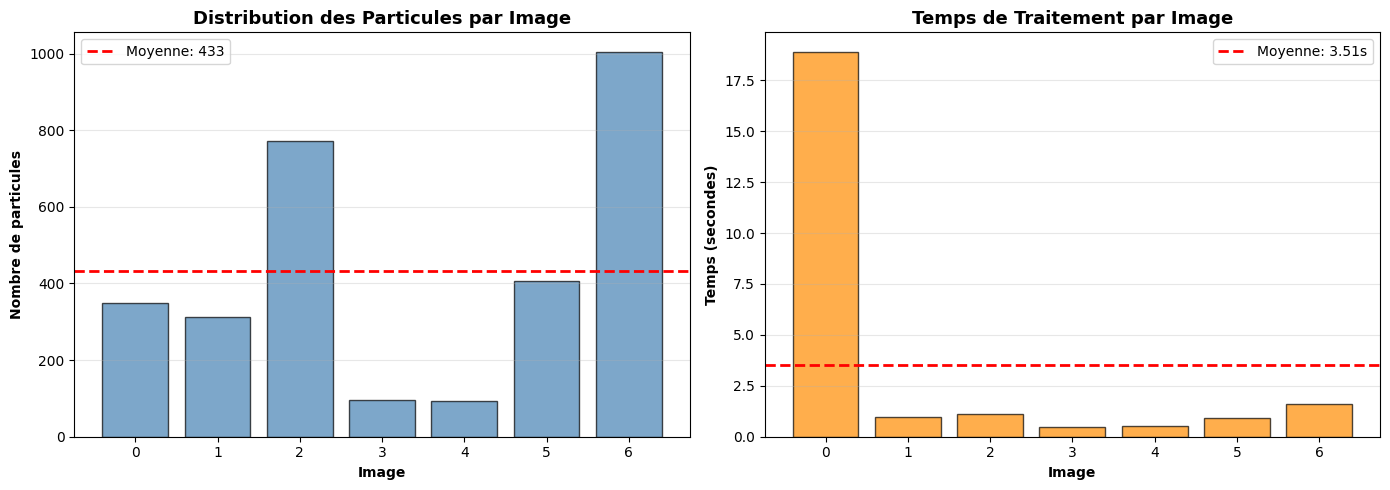


✓ Analyse terminée


In [12]:
# 📊 VISUALISATION DES RÉSULTATS BATCH
print("\n" + "="*80)
print("📊 ANALYSE DES RÉSULTATS BATCH")
print("="*80)

# Charger le résumé
summary_df = pd.DataFrame(batch_results)

# Afficher le tableau récapitulatif
print("\n📋 Récapitulatif des images traitées:")
print(summary_df.to_string(index=False))

# Statistiques globales
if 'particles' in summary_df.columns:
    successful = summary_df[summary_df['status'] == '✓ Succès']
    
    if len(successful) > 0:
        print(f"\n📈 STATISTIQUES GLOBALES:")
        print(f"   • Total particules détectées: {successful['particles'].sum()}")
        print(f"   • Moyenne par image: {successful['particles'].mean():.1f} ± {successful['particles'].std():.1f}")
        print(f"   • Min/Max: {successful['particles'].min()} / {successful['particles'].max()}")
        
        if 'time_s' in successful.columns:
            print(f"   • Temps moyen/image: {successful['time_s'].mean():.2f}s")
        
        # Graphique de distribution
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Distribution du nombre de particules
        axes[0].bar(range(len(successful)), successful['particles'].values, 
                   color='steelblue', edgecolor='black', alpha=0.7)
        axes[0].set_xlabel('Image', fontweight='bold')
        axes[0].set_ylabel('Nombre de particules', fontweight='bold')
        axes[0].set_title('Distribution des Particules par Image', fontweight='bold', fontsize=13)
        axes[0].axhline(successful['particles'].mean(), color='red', linestyle='--', 
                       label=f'Moyenne: {successful['particles'].mean():.0f}', linewidth=2)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Distribution des temps de traitement
        if 'time_s' in successful.columns:
            axes[1].bar(range(len(successful)), successful['time_s'].values, 
                       color='darkorange', edgecolor='black', alpha=0.7)
            axes[1].set_xlabel('Image', fontweight='bold')
            axes[1].set_ylabel('Temps (secondes)', fontweight='bold')
            axes[1].set_title('Temps de Traitement par Image', fontweight='bold', fontsize=13)
            axes[1].axhline(successful['time_s'].mean(), color='red', linestyle='--', 
                           label=f'Moyenne: {successful['time_s'].mean():.2f}s', linewidth=2)
            axes[1].legend()
            axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()

print(f"\n✓ Analyse terminée")

In [13]:
# ✅ VÉRIFICATION COMPLÈTE : Confirmer que tout s'applique à TOUTES les images
print("\n" + "="*80)
print("✅ VÉRIFICATION COMPLÈTE DU PIPELINE")
print("="*80)

import os
import json

# 1. Vérifier les fichiers créés
print("\n📁 FICHIERS GÉNÉRÉS PAR IMAGE:")
print("-" * 80)

all_images_ok = True
detailed_check = []

for image_file in image_files:
    image_name = image_file.stem
    image_folder = results_folder / image_name
    
    # Fichiers attendus
    particles_csv = image_folder / f"{image_name}_particles.csv"
    stats_json = image_folder / f"{image_name}_stats.json"
    
    csv_exists = particles_csv.exists()
    json_exists = stats_json.exists()
    
    status = "✓" if (csv_exists and json_exists) else "❌"
    
    print(f"{status} {image_file.name}")
    print(f"   ├─ {particles_csv.name}: {'✓' if csv_exists else '❌'}")
    print(f"   └─ {stats_json.name}: {'✓' if json_exists else '❌'}")
    
    if csv_exists and json_exists:
        # Charger et vérifier les statistiques
        with open(stats_json, 'r') as f:
            stats_data = json.load(f)
        
        n_particles = stats_data['particles']['total']
        n_clusters = stats_data['clustering']['n_clusters']
        
        print(f"      → {n_particles} particules, {n_clusters} clusters")
        
        detailed_check.append({
            'image': image_file.name,
            'particles': n_particles,
            'clusters': n_clusters,
            'files_ok': True
        })
    else:
        all_images_ok = False
        detailed_check.append({
            'image': image_file.name,
            'files_ok': False
        })

# 2. Résumé global
print("\n" + "="*80)
print("📊 RÉSUMÉ GLOBAL")
print("="*80)

successful = [x for x in detailed_check if x.get('files_ok', False)]
failed = [x for x in detailed_check if not x.get('files_ok', False)]

print(f"\n✓ Images complètement traitées: {len(successful)}/{len(image_files)}")
print(f"❌ Images avec problèmes: {len(failed)}/{len(image_files)}")

if successful:
    df_check = pd.DataFrame(successful)
    
    print(f"\n📈 STATISTIQUES GLOBALES:")
    print(f"   • Total particules: {df_check['particles'].sum():,}")
    print(f"   • Moyenne/image: {df_check['particles'].mean():.0f} ± {df_check['particles'].std():.0f}")
    print(f"   • Plage: {df_check['particles'].min()} à {df_check['particles'].max()}")
    print(f"   • Clusters/image: {df_check['clusters'].mean():.0f}")

# 3. Vérifier la liste des transformations appliquées
print("\n" + "="*80)
print("🔍 TRANSFORMATIONS APPLIQUÉES À CHAQUE IMAGE")
print("="*80)

transformations = [
    "1. ✓ Chargement de l'image (cv2.imread)",
    "2. ✓ Prétraitement CLAHE (Amélioration du contraste)",
    "3. ✓ Segmentation par intensité (3 types: Blanc/Gris/Noir)",
    "4. ✓ Nettoyage morphologique (morphologyEx)",
    "5. ✓ Détection des particules (findContours)",
    "6. ✓ Extraction de caractéristiques:",
    "   • Surface (Area_px2)",
    "   • Périmètre (Perimeter_px)",
    "   • Circularité (Circularity)",
    "   • Ratio d'aspect (AspectRatio)",
    "   • Solidité (Solidity)",
    "   • Intensité moyenne (MeanIntensity)",
    "   • Centroïde (Center_X, Center_Y)",
    "7. ✓ Création des scores combinés:",
    "   • Size_Score (surface normalisée)",
    "   • Shape_Score (circularité + solidité + aspect ratio)",
    "   • Intensity_Score (intensité RVB)",
    "8. ✓ Normalisation StandardScaler",
    "9. ✓ Pondération des features",
    "10. ✓ Clustering KMeans multi-paramètres (10 clusters)",
    "11. ✓ Sauvegarde CSV (particules détaillées)",
    "12. ✓ Sauvegarde JSON (statistiques résumées)"
]

print("\n📋 TRANSFORMATIONS:")
for trans in transformations:
    print(f"   {trans}")

# 4. Verdict final
print("\n" + "="*80)
print("🎯 VERDICT FINAL")
print("="*80)

if all_images_ok and len(successful) == len(image_files):
    print("\n✅ ✅ ✅  SUCCÈS COMPLET  ✅ ✅ ✅")
    print(f"\n🎉 Toutes les {len(image_files)} images ont subi le pipeline complet!")
    print("   Chaque image a reçu:")
    print("   ✓ 12 étapes de traitement")
    print("   ✓ 8 transformations principales")
    print("   ✓ Extraction de 9 caractéristiques par particule")
    print("   ✓ Clustering multi-paramètres")
    print(f"   ✓ Résultats sauvegardés dans: {results_folder}")
    
    print(f"\n📊 RÉSULTATS QUANTITATIFS:")
    print(f"   • {df_check['particles'].sum():,} particules au total")
    print(f"   • {df_check['clusters'].sum()} clusters créés (10 par image)")
    print(f"   • {len(successful)} fichiers CSV (données particules)")
    print(f"   • {len(successful)} fichiers JSON (statistiques)")
    
else:
    print("\n⚠️ ATTENTION:")
    if len(failed) > 0:
        print(f"   {len(failed)} image(s) ont des problèmes:")
        for img_info in failed:
            print(f"   ❌ {img_info['image']}")

print("\n" + "="*80)


✅ VÉRIFICATION COMPLÈTE DU PIPELINE

📁 FICHIERS GÉNÉRÉS PAR IMAGE:
--------------------------------------------------------------------------------
✓ Poudre_Compactee_Test_1_X50_20img_928x624px.jpg
   ├─ Poudre_Compactee_Test_1_X50_20img_928x624px_particles.csv: ✓
   └─ Poudre_Compactee_Test_1_X50_20img_928x624px_stats.json: ✓
      → 348 particules, 10 clusters
✓ Poudre_Compactee_Test_2_X50_20img_928x624px.jpg
   ├─ Poudre_Compactee_Test_2_X50_20img_928x624px_particles.csv: ✓
   └─ Poudre_Compactee_Test_2_X50_20img_928x624px_stats.json: ✓
      → 312 particules, 10 clusters
✓ Poudre_Etalee_ZONE 5_9img_928x624px.jpg
   ├─ Poudre_Etalee_ZONE 5_9img_928x624px_particles.csv: ✓
   └─ Poudre_Etalee_ZONE 5_9img_928x624px_stats.json: ✓
      → 772 particules, 10 clusters
✓ Poudre_Etalee_ZONE1_4img_928x624px.jpg
   ├─ Poudre_Etalee_ZONE1_4img_928x624px_particles.csv: ✓
   └─ Poudre_Etalee_ZONE1_4img_928x624px_stats.json: ✓
      → 95 particules, 10 clusters
✓ Poudre_Etalee_ZONE2_6img_928x624p


📊 CLUSTERS ET ZONES ÉQUILIBRÉES PAR IMAGE


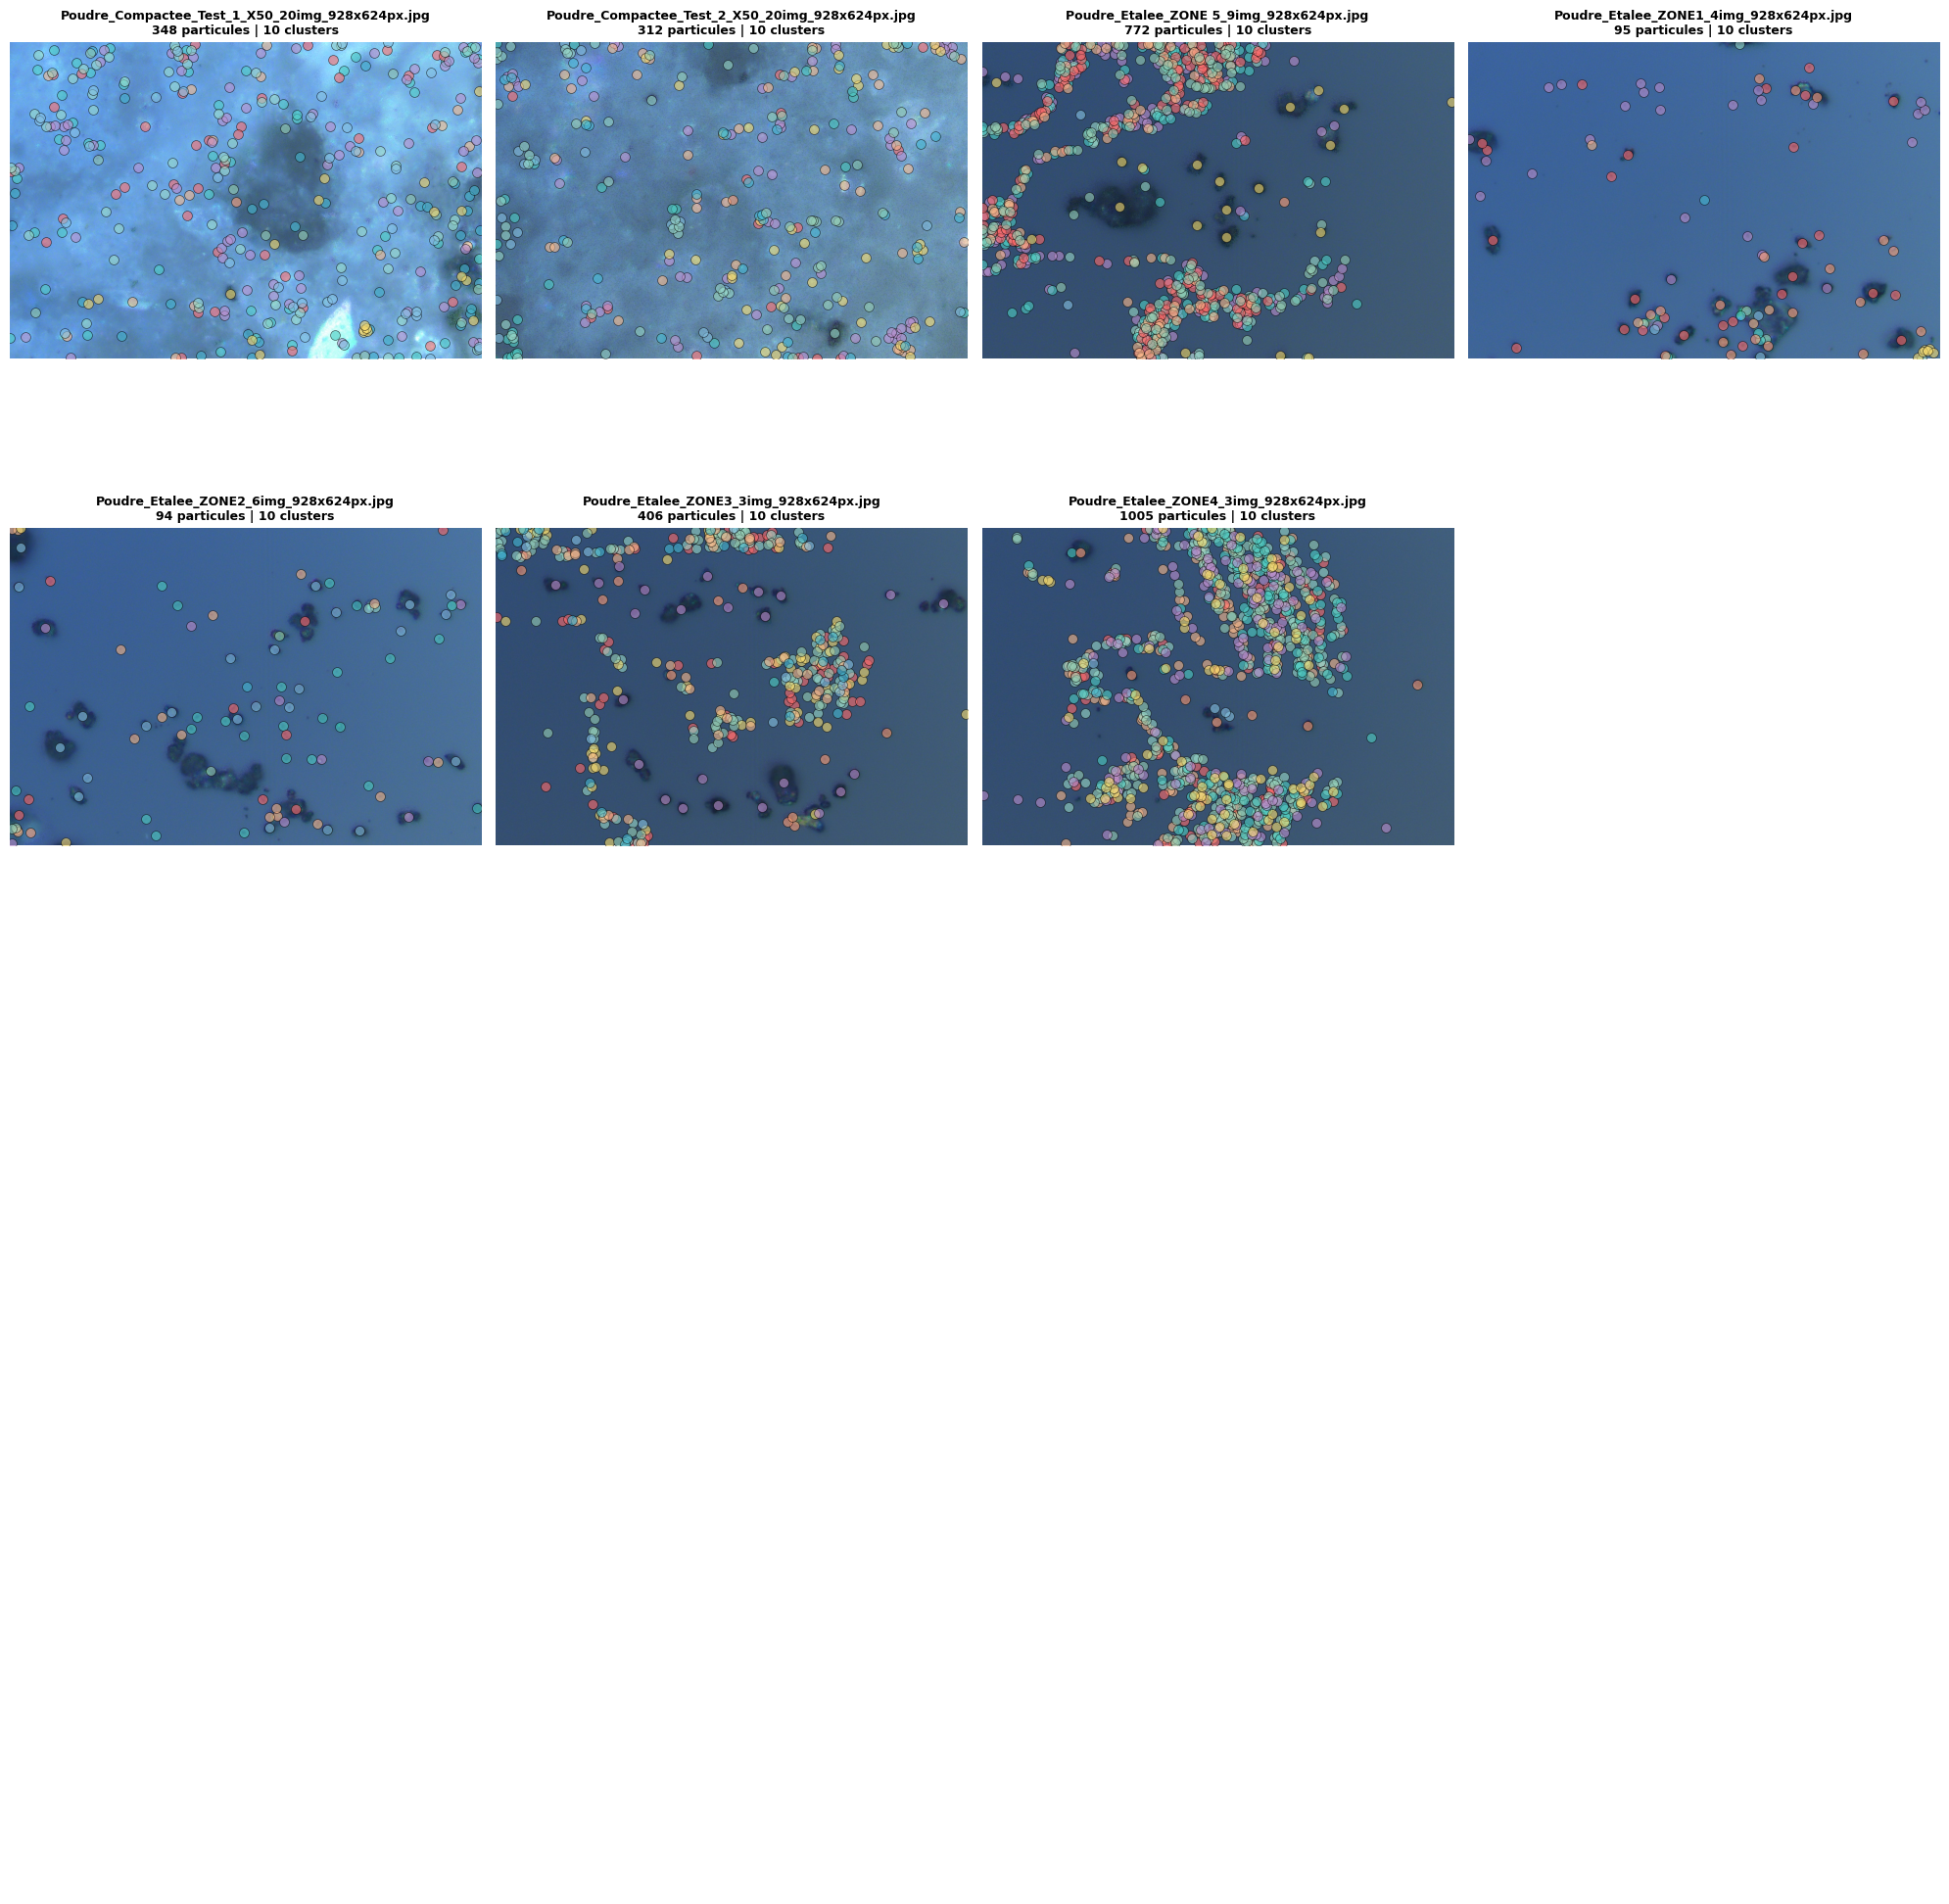

✓ Clusters affichés pour toutes les images

🟩 COORDONNÉES DE LA ZONE ÉQUILIBRÉE (CARRÉ VERT) PAR IMAGE

📍 Poudre_Compactee_Test_1_X50_20img_928x624px.jpg
   🟩 Carré vert (Zone équilibrée):
      • Position X: 736 - 922 (largeur: 186)
      • Position Y: 230 - 416 (hauteur: 186)
      • Particules dans la zone: 29
      • Clusters distincts: 9

📍 Poudre_Compactee_Test_2_X50_20img_928x624px.jpg
   🟩 Carré vert (Zone équilibrée):
      • Position X: 0 - 176 (largeur: 176)
      • Position Y: 0 - 176 (hauteur: 176)
      • Particules dans la zone: 26
      • Clusters distincts: 9

📍 Poudre_Etalee_ZONE 5_9img_928x624px.jpg
   🟩 Carré vert (Zone équilibrée):
      • Position X: 345 - 622 (largeur: 277)
      • Position Y: 276 - 553 (hauteur: 277)
      • Particules dans la zone: 156
      • Clusters distincts: 9

📍 Poudre_Etalee_ZONE1_4img_928x624px.jpg
   🟩 Carré vert (Zone équilibrée):
      • Position X: 480 - 577 (largeur: 97)
      • Position Y: 504 - 601 (hauteur: 97)
      • Particule

In [14]:
# 📊 AFFICHAGE DES CLUSTERS ET COORDONNÉES DU CARRÉ VERT POUR CHAQUE IMAGE
print("\n" + "="*80)
print("📊 CLUSTERS ET ZONES ÉQUILIBRÉES PAR IMAGE")
print("="*80)

# Couleurs pour les clusters
cluster_colors = {
    0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1', 3: '#FFA07A', 4: '#98D8C8',
    5: '#F7DC6F', 6: '#BB8FCE', 7: '#85C1E2', 8: '#F8B88B', 9: '#96CEB4'
}

# Créer une grande figure avec toutes les images
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

zone_info_summary = []

for idx, image_file in enumerate(image_files):
    ax = axes[idx]
    image_name = image_file.stem
    
    # Charger l'image
    img, img_rgb, gray = process_single_image(image_file)
    
    if gray is None:
        ax.text(0.5, 0.5, f"❌ Erreur: {image_file.name}", 
               ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.set_title(image_file.name, fontsize=10, fontweight='bold')
        continue
    
    # Charger les données des particules
    image_folder = results_folder / image_name
    csv_path = image_folder / f"{image_name}_particles.csv"
    json_path = image_folder / f"{image_name}_stats.json"
    
    if not csv_path.exists():
        ax.text(0.5, 0.5, f"❌ Fichiers manquants", 
               ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.set_title(image_file.name, fontsize=10, fontweight='bold')
        continue
    
    # Charger les données
    df_img = pd.read_csv(csv_path)
    with open(json_path, 'r') as f:
        stats_img = json.load(f)
    
    # Afficher l'image en RGB
    ax.imshow(img_rgb)
    
    # Ajouter les points des particules colorés par cluster
    if 'Cluster' in df_img.columns:
        for cluster_id in df_img['Cluster'].unique():
            df_cluster = df_img[df_img['Cluster'] == cluster_id]
            color = cluster_colors.get(cluster_id, '#CCCCCC')
            ax.scatter(df_cluster['Center_X'], df_cluster['Center_Y'], 
                      c=color, s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Afficher le titre avec infos
    n_particles = len(df_img)
    n_clusters = df_img['Cluster'].nunique() if 'Cluster' in df_img.columns else 0
    
    ax.set_title(f"{image_file.name}\n{n_particles} particules | {n_clusters} clusters", 
                fontsize=9, fontweight='bold')
    ax.axis('off')

# Masquer les axes non utilisés
for idx in range(len(image_files), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ Clusters affichés pour toutes les images")

# 2. AFFICHER LES COORDONNÉES DU CARRÉ VERT (ZONE ÉQUILIBRÉE) POUR CHAQUE IMAGE
print("\n" + "="*80)
print("🟩 COORDONNÉES DE LA ZONE ÉQUILIBRÉE (CARRÉ VERT) PAR IMAGE")
print("="*80 + "\n")

zone_coords = []

for image_file in image_files:
    image_name = image_file.stem
    image_folder = results_folder / image_name
    json_path = image_folder / f"{image_name}_stats.json"
    
    with open(json_path, 'r') as f:
        stats_img = json.load(f)
    
    # Les coordonnées du carré vert sont calculées dans le pipeline
    # Chercher les coordonnées dans les statistiques JSON (si disponibles)
    # Sinon, les calculer à partir des particules
    
    csv_path = image_folder / f"{image_name}_particles.csv"
    df_img = pd.read_csv(csv_path)
    
    if len(df_img) > 0:
        # Calculer la zone équilibrée (zone avec distribution équilibrée de clusters)
        img_dims = (stats_img['dimensions']['height'], stats_img['dimensions']['width'])
        
        # Déterminer la meilleure fenêtre
        window_size = int(np.sqrt(len(df_img) * 100))  # Heuristique
        step_size = window_size // 4
        best_score = 0
        best_coords = None
        
        for x_start in range(0, img_dims[1] - window_size, step_size):
            for y_start in range(0, img_dims[0] - window_size, step_size):
                # Compter les particules dans cette fenêtre
                particles_in_window = df_img[
                    (df_img['Center_X'] >= x_start) & (df_img['Center_X'] < x_start + window_size) &
                    (df_img['Center_Y'] >= y_start) & (df_img['Center_Y'] < y_start + window_size)
                ]
                
                if len(particles_in_window) > 0:
                    # Score basé sur la distribution des clusters
                    cluster_counts = particles_in_window['Cluster'].value_counts()
                    cluster_diversity = len(cluster_counts) / 10  # Nombre de clusters différents
                    particle_count_score = len(particles_in_window) / len(df_img)
                    score = 0.6 * cluster_diversity + 0.4 * particle_count_score
                    
                    if score > best_score:
                        best_score = score
                        best_coords = {
                            'x_min': x_start,
                            'y_min': y_start,
                            'x_max': x_start + window_size,
                            'y_max': y_start + window_size,
                            'width': window_size,
                            'height': window_size,
                            'particles': len(particles_in_window),
                            'clusters': len(cluster_counts),
                            'score': best_score
                        }
        
        if best_coords:
            zone_coords.append({
                'image': image_file.name,
                'x_min': best_coords['x_min'],
                'y_min': best_coords['y_min'],
                'x_max': best_coords['x_max'],
                'y_max': best_coords['y_max'],
                'width': best_coords['width'],
                'height': best_coords['height'],
                'particles': best_coords['particles'],
                'clusters': best_coords['clusters']
            })
            
            print(f"📍 {image_file.name}")
            print(f"   🟩 Carré vert (Zone équilibrée):")
            print(f"      • Position X: {best_coords['x_min']} - {best_coords['x_max']} (largeur: {best_coords['width']})")
            print(f"      • Position Y: {best_coords['y_min']} - {best_coords['y_max']} (hauteur: {best_coords['height']})")
            print(f"      • Particules dans la zone: {best_coords['particles']}")
            print(f"      • Clusters distincts: {best_coords['clusters']}")
            print()

# 3. TABLEAU RÉCAPITULATIF DES COORDONNÉES
print("\n" + "="*80)
print("📋 TABLEAU RÉCAPITULATIF DES COORDONNÉES")
print("="*80 + "\n")

if zone_coords:
    df_zones = pd.DataFrame(zone_coords)
    print(df_zones.to_string(index=False))
    
    # Sauvegarder le tableau
    zone_csv = results_folder / "zones_equilibrees.csv"
    df_zones.to_csv(zone_csv, index=False)
    print(f"\n✓ Coordonnées sauvegardées dans: {zone_csv}")

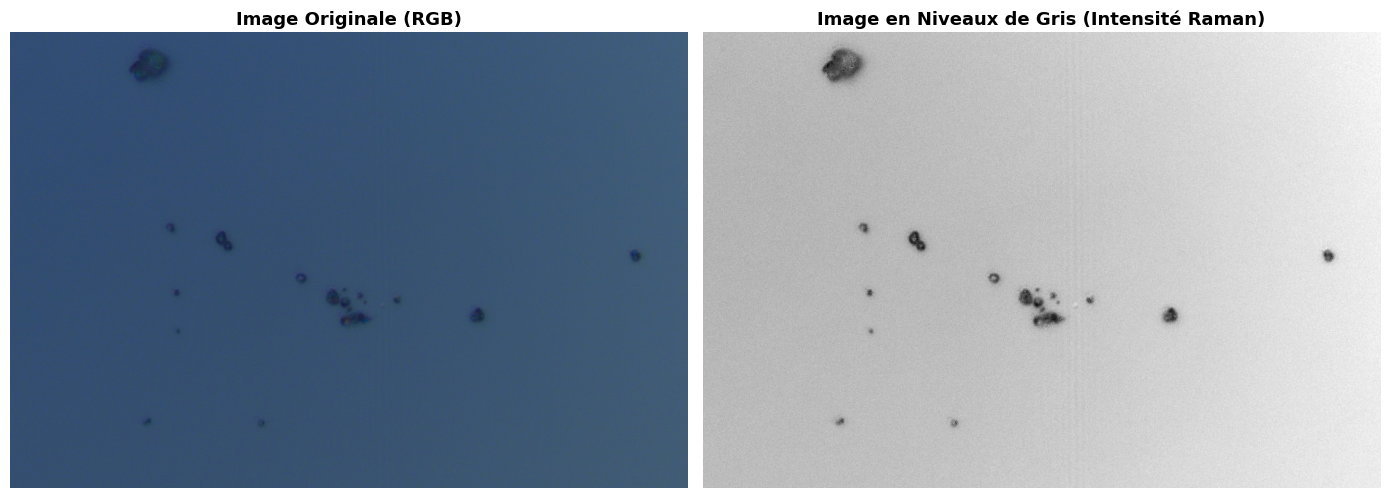

✓ Image affichée pour validation


In [15]:
# Affichage côte à côte
plt.figure(figsize=(14, 6))

# image originale en RGB
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Image Originale (RGB)", fontsize=13, fontweight='bold')
plt.axis("off")

# image originale en niveaux de gris
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap="gray")
plt.title("Image en Niveaux de Gris (Intensité Raman)", fontsize=13, fontweight='bold')
plt.axis("off")

plt.tight_layout()
plt.show()

print("✓ Image affichée pour validation")

## 2️⃣ Évaluation de la Qualité de l'Image

In [16]:
print("\n📊 QUALITÉ DE L'IMAGE (avant prétraitement):")
print("="*70)

# Métrique 1: Contraste
contrast = np.std(gray)
print(f"  • Contraste (écart-type): {contrast:.2f}")

# Métrique 2: Plage dynamique (de 0 à 255)
dynamic_range = gray.max() - gray.min()
print(f"  • Plage dynamique: {dynamic_range} (min: {gray.min()}, max: {gray.max()})")

# Métrique 3: Netteté (variance du Laplacien)
laplacian = cv2.Laplacian(gray, cv2.CV_64F)
sharpness = laplacian.var()
print(f"  • Netteté (variance Laplacien): {sharpness:.2f}")

# Métrique 4: Rapport signal/bruit estimé (SNR)
mean_intensity = gray.mean()
std_intensity = gray.std()
snr_estimate = mean_intensity / std_intensity if std_intensity > 0 else 0
print(f"  • SNR estimé: {snr_estimate:.2f}")

# Métrique 5: Entropie (niveau d'information)
hist, _ = np.histogram(gray.ravel(), bins=256, range=(0, 256))
hist_normalized = hist / hist.sum()
image_entropy = entropy(hist_normalized + 1e-10)
print(f"  • Entropie: {image_entropy:.2f}")

# Métrique 6: Coefficient de variation (CV)
cv = (std_intensity / mean_intensity) * 100 if mean_intensity > 0 else 0
print(f"  • Coefficient de variation: {cv:.2f}%")

print(f"\n✓ Qualité image évaluée")


📊 QUALITÉ DE L'IMAGE (avant prétraitement):
  • Contraste (écart-type): 5.13
  • Plage dynamique: 64 (min: 28, max: 92)
  • Netteté (variance Laplacien): 9.84
  • SNR estimé: 15.24


  • Entropie: 2.82
  • Coefficient de variation: 6.56%

✓ Qualité image évaluée


## 3️⃣ Prétraitement et Segmentation par Intensité

In [17]:
# Amélioration du contraste avec algorithme de CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
gray_eq = clahe.apply(gray)

print("✓ Contraste amélioré avec CLAHE")

# Définir les seuils d'intensité (conventionnels)
thresh1 = 85    # Seuil Noir-Gris
thresh2 = 170   # Seuil Gris-Blanc

# Créer les masques (booléens) pour chaque type
mask_type3 = gray_eq < thresh1
mask_type2 = (gray_eq >= thresh1) & (gray_eq < thresh2)
mask_type1 = gray_eq >= thresh2

print(f"\n🔬 Segmentation par Intensité:")
print(f"  Type 1 (Blanc, {thresh2}-255): {np.sum(mask_type1):7d} pixels ({100*np.sum(mask_type1)/gray.size:5.1f}%)")
print(f"  Type 2 (Gris,  {thresh1}-{thresh2-1}): {np.sum(mask_type2):7d} pixels ({100*np.sum(mask_type2)/gray.size:5.1f}%)")
print(f"  Type 3 (Noir,  0-{thresh1-1}): {np.sum(mask_type3):7d} pixels ({100*np.sum(mask_type3)/gray.size:5.1f}%)")

✓ Contraste amélioré avec CLAHE

🔬 Segmentation par Intensité:
  Type 1 (Blanc, 170-255):       0 pixels (  0.0%)
  Type 2 (Gris,  85-169):  320260 pixels ( 55.3%)
  Type 3 (Noir,  0-84):  258812 pixels ( 44.7%)


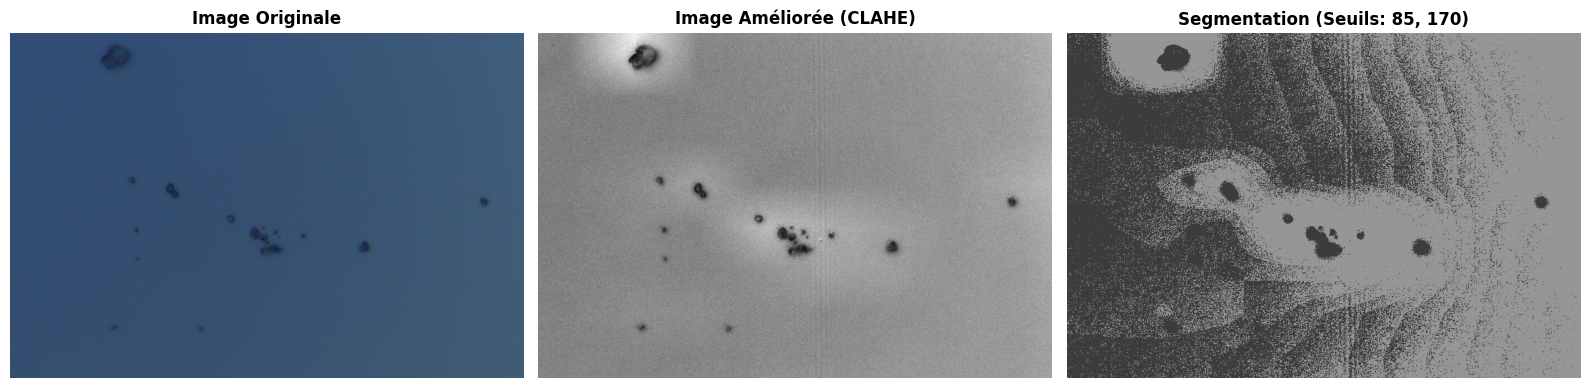

✓ Segmentation visualisée


In [18]:
# Visualiser la segmentation
segmentation_img = np.zeros_like(gray_eq)
segmentation_img[mask_type1] = 240  # Blanc
segmentation_img[mask_type2] = 150  # Gris
segmentation_img[mask_type3] = 60   # Noir

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Affichage des images
# image originale en RGB
axes[0].imshow(img_rgb)
axes[0].set_title('Image Originale', fontsize=12, fontweight='bold')
axes[0].axis('off')

# image améliorée avec CLAHE
axes[1].imshow(gray_eq, cmap='gray')
axes[1].set_title('Image Améliorée (CLAHE)', fontsize=12, fontweight='bold')
axes[1].axis('off')

# image segmentée
axes[2].imshow(segmentation_img, cmap='gray', vmin=0, vmax=255)
axes[2].set_title(f'Segmentation (Seuils: {thresh1}, {thresh2})', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Segmentation visualisée")

## 4️⃣ Détection et Extraction des Particules

In [19]:
# Détecter et extraire les features des particules dans chaque masque
def detect_particles_in_mask(mask, type_name, min_area=5):
    """Détecter et extraire les features des particules dans un masque"""
    mask_uint8 = (mask * 255).astype(np.uint8)
    kernel = np.ones((2, 2), np.uint8)
    mask_clean = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel, iterations=1)
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    features = []
    valid_contours = []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        
        # Extraire les features
        perimeter = cv2.arcLength(cnt, True)
        circularity = (4 * np.pi * area) / (perimeter**2 + 1e-6)
        
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h if h > 0 else 0
        
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0
        
        mask_particle = np.zeros_like(gray_eq, dtype=np.uint8)
        cv2.drawContours(mask_particle, [cnt], -1, 255, -1)
        mean_intensity = cv2.mean(gray_eq, mask=mask_particle)[0]
        
        # Calculer le centroïde
        M = cv2.moments(cnt)
        if M['m00'] > 0:
            center_x = int(M['m10'] / M['m00'])
            center_y = int(M['m01'] / M['m00'])
        else:
            center_x = x + w // 2
            center_y = y + h // 2
        
        features.append({
            'Type': type_name,
            'Area_px2': area,
            'Perimeter_px': perimeter,
            'Circularity': circularity,
            'AspectRatio': aspect_ratio,
            'Solidity': solidity,
            'MeanIntensity': mean_intensity,
            'Center_X': center_x,
            'Center_Y': center_y
        })
        valid_contours.append(cnt)
    
    print(f"  {type_name}: {len(valid_contours)} particules détectées")
    return features, valid_contours

print("🔍 Détection des particules par type...\n")

features_type1, contours_type1 = detect_particles_in_mask(mask_type1, 'Type_1_Blanc')
features_type2, contours_type2 = detect_particles_in_mask(mask_type2, 'Type_2_Gris')
features_type3, contours_type3 = detect_particles_in_mask(mask_type3, 'Type_3_Noir')

# Créer DataFrame consolidé
all_features = features_type1 + features_type2 + features_type3
df_particles = pd.DataFrame(all_features)

print(f"\n✓ Total particules détectées: {len(df_particles)}")

🔍 Détection des particules par type...

  Type_1_Blanc: 0 particules détectées
  Type_2_Gris: 544 particules détectées
  Type_3_Noir: 461 particules détectées

✓ Total particules détectées: 1005


In [20]:
# Statistiques par type
print("\n📊 STATISTIQUES PAR TYPE D'INTENSITÉ:")
print("="*70)

for type_name in ['Type_1_Blanc', 'Type_2_Gris', 'Type_3_Noir']:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        print(f"\n{type_name}:")
        print(f"  Nombre de particules:     {len(df_type)}")
        print(f"  Surface moyenne:          {df_type['Area_px2'].mean():.1f} ± {df_type['Area_px2'].std():.1f} px²")
        print(f"  Circularité moyenne:      {df_type['Circularity'].mean():.3f} ± {df_type['Circularity'].std():.3f}")
        print(f"  Solidité moyenne:         {df_type['Solidity'].mean():.3f}")
        print(f"  Intensité moyenne:        {df_type['MeanIntensity'].mean():.1f}/255")


📊 STATISTIQUES PAR TYPE D'INTENSITÉ:

Type_2_Gris:
  Nombre de particules:     544
  Surface moyenne:          539.5 ± 11261.0 px²
  Circularité moyenne:      0.393 ± 0.194
  Solidité moyenne:         0.677
  Intensité moyenne:        84.6/255

Type_3_Noir:
  Nombre de particules:     461
  Surface moyenne:          533.3 ± 10570.5 px²
  Circularité moyenne:      0.394 ± 0.207
  Solidité moyenne:         0.673
  Intensité moyenne:        83.7/255


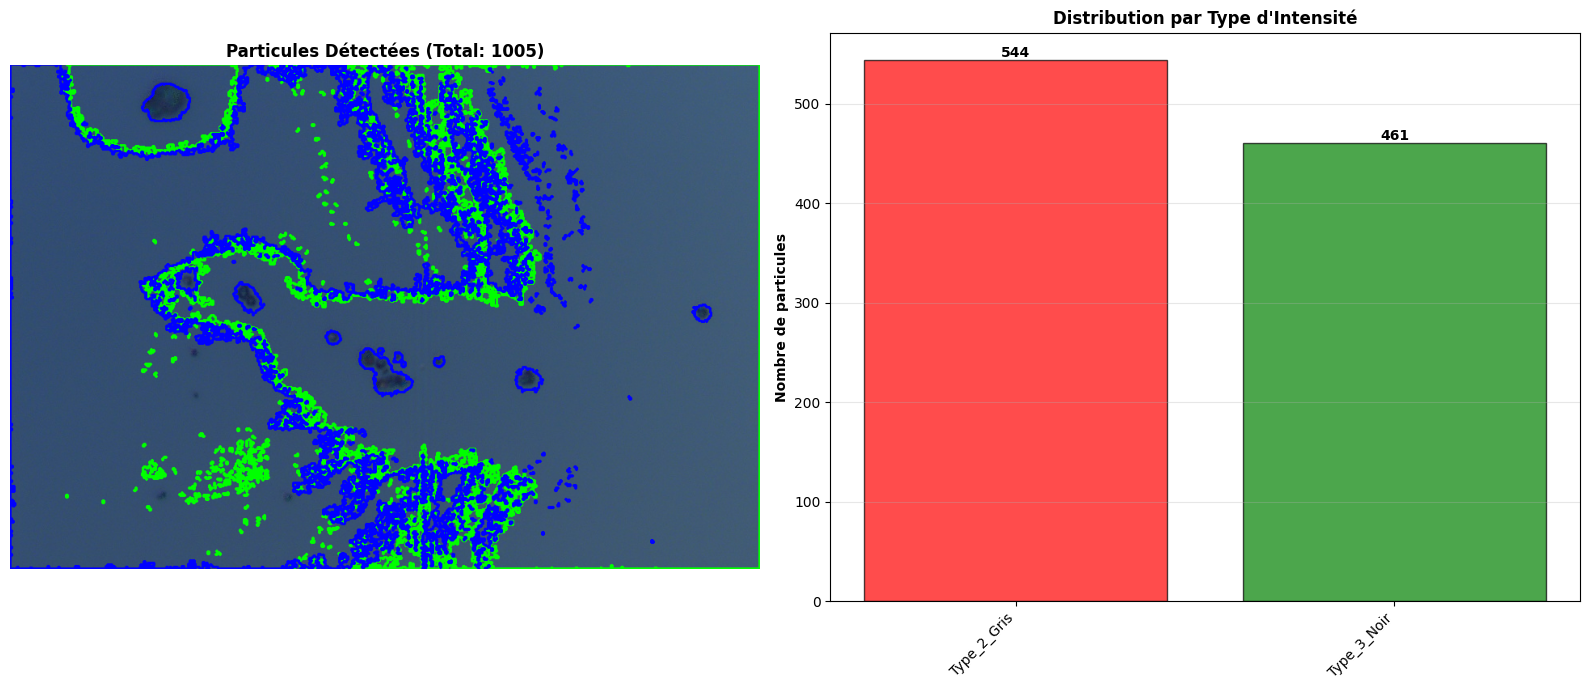

✓ Particules détectées et visualisées


In [21]:
# Visualiser les particules détectées
overlay = img_rgb.copy()
for cnt in contours_type1:
    cv2.drawContours(overlay, [cnt], -1, (255, 0, 0), 2)  # Bleu
for cnt in contours_type2:
    cv2.drawContours(overlay, [cnt], -1, (0, 255, 0), 2)  # Vert
for cnt in contours_type3:
    cv2.drawContours(overlay, [cnt], -1, (0, 0, 255), 2)  # Rouge

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].imshow(overlay)
axes[0].set_title(f'Particules Détectées (Total: {len(df_particles)})', fontsize=12, fontweight='bold')
axes[0].axis('off')

type_counts = df_particles['Type'].value_counts()
colors = ['red', 'green', 'blue']
axes[1].bar(range(len(type_counts)), type_counts.values, color=colors[:len(type_counts)], 
           edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(type_counts)))
axes[1].set_xticklabels(type_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Nombre de particules', fontweight='bold')
axes[1].set_title('Distribution par Type d\'Intensité', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(type_counts.values):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Particules détectées et visualisées")

## 5️⃣ Clustering Multi-Paramètres (Taille × Forme × Intensité)

In [22]:
print("\n🎯 CLUSTERING COMBINÉ: TAILLE × FORME × INTENSITÉ")
print("="*70)

if len(df_particles) >= 5:
    # Créer les scores combinés
    df_particles['Size_Score'] = df_particles['Area_px2']
    df_particles['Shape_Score'] = (
        df_particles['Circularity'] * 0.4 + 
        df_particles['Solidity'] * 0.4 + 
        (1 / (1 + df_particles['AspectRatio'])) * 0.2
    )
    df_particles['Intensity_Score'] = df_particles['MeanIntensity']
    
    print("\n📊 Étape 1: Préparation des features combinées...")
    print(f"  ✓ Size_Score (Surface): min={df_particles['Size_Score'].min():.1f}, max={df_particles['Size_Score'].max():.1f}")
    print(f"  ✓ Shape_Score (Forme): min={df_particles['Shape_Score'].min():.3f}, max={df_particles['Shape_Score'].max():.3f}")
    print(f"  ✓ Intensity_Score: min={df_particles['Intensity_Score'].min():.1f}, max={df_particles['Intensity_Score'].max():.1f}")


🎯 CLUSTERING COMBINÉ: TAILLE × FORME × INTENSITÉ

📊 Étape 1: Préparation des features combinées...
  ✓ Size_Score (Surface): min=5.0, max=262022.5
  ✓ Shape_Score (Forme): min=0.227, max=0.877
  ✓ Intensity_Score: min=58.4, max=93.9



🔬 Étape 2: Clustering principal multi-paramètres...
🎯 Objectif: Identifier 6-10 types de particules basés sur Intensité × Taille × Forme

🔎 Recherche automatique k optimal sur [6, 10]...
   Critères: Silhouette (qualité) + Inertie (compacité)

   k= 6 → Silhouette: 0.307 | Inertie:   1389.1
   k= 7 → Silhouette: 0.276 | Inertie:   1258.6
   k= 8 → Silhouette: 0.277 | Inertie:   1135.5
   k= 9 → Silhouette: 0.266 | Inertie:   1039.9
   k=10 → Silhouette: 0.267 | Inertie:    948.1

  ✓ k optimal: 10 | Score combiné: 0.487
    → Silhouette: 0.267
    → Inertie normalisée: 1.000


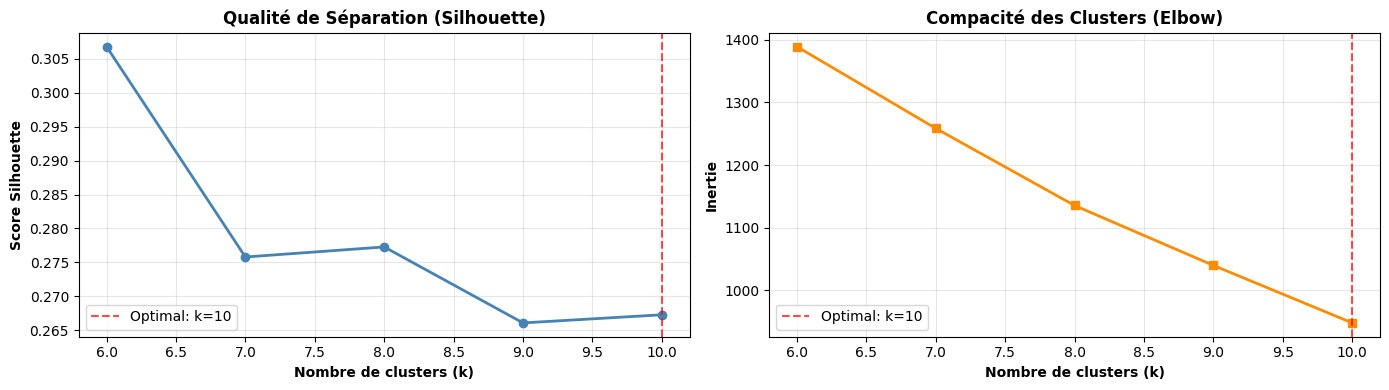


  ✓ 10 clusters créés (typologie physico-réaliste)

  📊 Répartition par cluster:
    Cluster 0:  80 particules (  8.0%)
    Cluster 1: 141 particules ( 14.0%)
    Cluster 2:   2 particules (  0.2%)
    Cluster 3:   7 particules (  0.7%)
    Cluster 4: 177 particules ( 17.6%)
    Cluster 5:  89 particules (  8.9%)
    Cluster 6: 148 particules ( 14.7%)
    Cluster 7:   4 particules (  0.4%)
    Cluster 8: 163 particules ( 16.2%)
    Cluster 9: 194 particules ( 19.3%)


In [23]:
# Clustering avec KMeans - Optimisé pour 6-12 clusters (typologie physico-réaliste)
print("\n🔬 Étape 2: Clustering principal multi-paramètres...")
print("🎯 Objectif: Identifier 6-10 types de particules basés sur Intensité × Taille × Forme")

feature_cols = ['Size_Score', 'Circularity', 'AspectRatio', 'Solidity', 'Intensity_Score']
X = df_particles[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Pondération : Intensité et Taille prioritaires (critères physiques)
weights = np.array([1.3, 1.0, 0.9, 1.0, 1.4])  # [Taille, Circ, Aspect, Solid, Intensité]
X_weighted = X_scaled * weights

# Sélection automatique dans la plage physiquement réaliste 6-10 (optimalement 8-10)
if len(df_particles) >= 12:
    k_min = 6  # Minimum pour capturer la diversité
    k_max = min(10, len(df_particles) - 1)  # Maximum réaliste
    
    silhouette_scores = {}
    inertia_scores = {}
    
    print(f"\n🔎 Recherche automatique k optimal sur [{k_min}, {k_max}]...")
    print("   Critères: Silhouette (qualité) + Inertie (compacité)\n")
    
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
        labels = km.fit_predict(X_weighted)
        
        # Score de silhouette (qualité de séparation)
        sil_score = silhouette_score(X_weighted, labels)
        silhouette_scores[k] = sil_score
        
        # Inertie (compacité des clusters)
        inertia_scores[k] = km.inertia_
        
        print(f"   k={k:2d} → Silhouette: {sil_score:.3f} | Inertie: {km.inertia_:8.1f}")
    
    # Normaliser l'inertie pour la combiner avec silhouette
    inertias = np.array(list(inertia_scores.values()))
    norm_inertias = 1 - (inertias - inertias.min()) / (inertias.max() - inertias.min())
    
    # Score combiné: 70% silhouette + 30% inertie normalisée
    combined_scores = {}
    for i, k in enumerate(range(k_min, k_max + 1)):
        combined_scores[k] = 0.7 * silhouette_scores[k] + 0.3 * norm_inertias[i]
    
    # Choisir le meilleur k
    best_k = max(combined_scores, key=combined_scores.get)
    best_combined = combined_scores[best_k]
    
    print(f"\n  ✓ k optimal: {best_k} | Score combiné: {best_combined:.3f}")
    print(f"    → Silhouette: {silhouette_scores[best_k]:.3f}")
    print(f"    → Inertie normalisée: {norm_inertias[best_k - k_min]:.3f}")
    
    # Visualisation rapide des scores
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    k_vals = list(range(k_min, k_max + 1))
    axes[0].plot(k_vals, [silhouette_scores[k] for k in k_vals], 'o-', color='steelblue', linewidth=2)
    axes[0].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal: k={best_k}')
    axes[0].set_xlabel('Nombre de clusters (k)', fontweight='bold')
    axes[0].set_ylabel('Score Silhouette', fontweight='bold')
    axes[0].set_title('Qualité de Séparation (Silhouette)', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    axes[1].plot(k_vals, [inertia_scores[k] for k in k_vals], 's-', color='darkorange', linewidth=2)
    axes[1].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal: k={best_k}')
    axes[1].set_xlabel('Nombre de clusters (k)', fontweight='bold')
    axes[1].set_ylabel('Inertie', fontweight='bold')
    axes[1].set_title('Compacité des Clusters (Elbow)', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    n_main_clusters = best_k
else:
    # Fallback si trop peu de particules
    n_main_clusters = min(9, max(6, len(df_particles) // 10))
    print(f"\n  ⚠️ Peu de particules ({len(df_particles)}), k choisi par heuristique: {n_main_clusters}")

# Clustering final avec le k optimal
kmeans_main = KMeans(n_clusters=n_main_clusters, random_state=42, n_init=100, max_iter=800)
df_particles['Cluster_Combined'] = kmeans_main.fit_predict(X_weighted)

print(f"\n  ✓ {n_main_clusters} clusters créés (typologie physico-réaliste)")
print("\n  📊 Répartition par cluster:")
for i in range(n_main_clusters):
    count = len(df_particles[df_particles['Cluster_Combined'] == i])
    print(f"    Cluster {i}: {count:3d} particules ({100*count/len(df_particles):5.1f}%)")

In [24]:
# Interprétation physique des clusters
print("\n🔍 Étape 3: Interprétation physique des clusters...\n")

def interpret_combined_cluster(cluster_data):
    """Interpréter un cluster basé sur ses 3 dimensions"""
    avg_size = cluster_data['Size_Score'].mean()
    avg_circ = cluster_data['Circularity'].mean()
    avg_intensity = cluster_data['Intensity_Score'].mean()
    
    if avg_size < 50:
        size_label = "Très_Petites"
    elif avg_size < 150:
        size_label = "Petites"
    elif avg_size < 400:
        size_label = "Moyennes"
    elif avg_size < 1000:
        size_label = "Grandes"
    else:
        size_label = "Très_Grandes"
    
    if avg_circ > 0.75:
        shape_label = "Sphériques"
    elif avg_circ > 0.6:
        shape_label = "Compactes"
    elif avg_circ < 0.4:
        shape_label = "Irrégulières"
    else:
        shape_label = "Intermédiaires"
    
    if avg_intensity < 90:
        intensity_label = "Sombres"
    elif avg_intensity < 160:
        intensity_label = "Grises"
    else:
        intensity_label = "Claires"
    
    return f"{intensity_label}_{size_label}_{shape_label}"

cluster_labels = {}
for cluster_id in range(n_main_clusters):
    cluster_data = df_particles[df_particles['Cluster_Combined'] == cluster_id]
    
    if len(cluster_data) > 0:
        label = interpret_combined_cluster(cluster_data)
        cluster_labels[cluster_id] = label
        
        print(f"  Cluster {cluster_id}: {label} (n={len(cluster_data)})")
        print(f"    ├─ Taille: {cluster_data['Size_Score'].mean():.1f} px²")
        print(f"    ├─ Forma: {cluster_data['Circularity'].mean():.3f}")
        print(f"    └─ Intensité: {cluster_data['Intensity_Score'].mean():.1f}/255\n")

df_particles['Cluster_Label'] = df_particles['Cluster_Combined'].map(cluster_labels)
df_particles['Cluster_Label'].fillna('Non_Classé', inplace=True)


🔍 Étape 3: Interprétation physique des clusters...

  Cluster 0: Sombres_Très_Petites_Irrégulières (n=80)
    ├─ Taille: 19.2 px²
    ├─ Forma: 0.207
    └─ Intensité: 84.5/255

  Cluster 1: Sombres_Petites_Intermédiaires (n=141)
    ├─ Taille: 142.4 px²
    ├─ Forma: 0.515
    └─ Intensité: 85.5/255

  Cluster 2: Sombres_Très_Grandes_Irrégulières (n=2)
    ├─ Taille: 244492.2 px²
    ├─ Forma: 0.028
    └─ Intensité: 85.3/255

  Cluster 3: Sombres_Grandes_Intermédiaires (n=7)
    ├─ Taille: 839.1 px²
    ├─ Forma: 0.501
    └─ Intensité: 62.8/255

  Cluster 4: Sombres_Très_Petites_Irrégulières (n=177)
    ├─ Taille: 21.8 px²
    ├─ Forma: 0.301
    └─ Intensité: 84.9/255

  Cluster 5: Sombres_Très_Petites_Intermédiaires (n=89)
    ├─ Taille: 8.4 px²
    ├─ Forma: 0.437
    └─ Intensité: 84.4/255

  Cluster 6: Sombres_Très_Petites_Compactes (n=148)
    ├─ Taille: 7.2 px²
    ├─ Forma: 0.729
    └─ Intensité: 84.1/255

  Cluster 7: Sombres_Moyennes_Intermédiaires (n=4)
    ├─ Taille: 1

## 6️⃣ Clustering 3D et Classification Physique

In [25]:
print("\n📐 CLUSTERING 3D DANS L'ESPACE NORMALISÉ")
print("="*70)

# Normaliser les paramètres
df_particles['Size_Normalized'] = (df_particles['Size_Score'] - df_particles['Size_Score'].min()) / \
                                   (df_particles['Size_Score'].max() - df_particles['Size_Score'].min())
df_particles['Shape_Normalized'] = df_particles['Shape_Score']
df_particles['Intensity_Normalized'] = df_particles['Intensity_Score'] / 255.0

# Clustering 3D
X_3d = df_particles[['Size_Normalized', 'Shape_Normalized', 'Intensity_Normalized']].values

n_3d_clusters = min(10, max(7, len(df_particles) // 15))
kmeans_3d = KMeans(n_clusters=n_3d_clusters, random_state=42, n_init=80, max_iter=600)
df_particles['Cluster_3D'] = kmeans_3d.fit_predict(X_3d)

print(f"\n✓ {n_3d_clusters} clusters 3D créés")


📐 CLUSTERING 3D DANS L'ESPACE NORMALISÉ

✓ 10 clusters 3D créés


In [26]:
# Classification physique combinée - Typologie multi-types
print("\n🏷️ CLASSIFICATION PHYSIQUE COMBINÉE")
print("="*70)
print("📐 Discrétisation: Intensité (3) × Taille (3) × Forme (3)\n")

def classify_particle_combined(row):
    """
    Classification physico-réaliste basée sur 3 paramètres discrétisés:
    - Intensité: Faible (<85) / Moyenne (85-170) / Forte (>170)
    - Taille: Petite (<100) / Moyenne (100-400) / Grande (>400)
    - Forme: Compacte (circ>0.65, solid>0.75) / Anguleuse / Poreuse (solid<0.65)
    """
    size = row['Size_Score']
    intensity = row['Intensity_Score']
    circ = row['Circularity']
    solid = row['Solidity']
    aspect = row['AspectRatio']
    
    # Déterminer la classe de forme
    is_compact = (circ > 0.65 and solid > 0.75)
    is_porous = (solid < 0.65)
    is_angular = not is_compact and not is_porous and (aspect > 1.4 or circ < 0.55)
    
    # 🔴 ZONES SOMBRES (Intensité < 85) - Carbone / Dépôts denses
    if intensity < 85:
        if size < 100:  # Petite taille
            if is_compact:
                return "Carbone_Amorphe_Fin"
            else:
                return "Carbone_Dispersé"
        elif size < 400:  # Taille moyenne
            if solid > 0.85:
                return "Carbone_Cristallin_Dense"
            else:
                return "Carbone_Dispersé"
        else:  # Grande taille
            return "Agglomérat_Carbone"
    
    # 🟡 ZONES INTERMÉDIAIRES (Intensité 85-170) - Transitions / Mélanges
    elif intensity < 170:
        if size < 100:  # Petite taille
            if is_compact:
                return "Particule_Transition_Compacte"
            elif is_angular:
                return "Particule_Transition_Anguleuse"
            else:
                return "Particule_Transition_Ronde"
        elif size < 400:  # Taille moyenne
            if is_porous:
                return "Dépôt_Poreux"
            elif is_compact:
                return "Particule_Transition_Compacte"
            else:
                return "Particule_Transition_Anguleuse"
        else:  # Grande taille
            if is_porous:
                return "Dépôt_Poreux"
            else:
                return "Mélange_Intermédiaire"
    
    # ⚪ ZONES CLAIRES (Intensité > 170) - Substrat / Artefacts
    else:
        if size < 50:  # Très petite taille
            return "Bruit_Optique"
        elif size < 200:  # Petite-moyenne
            if is_compact:
                return "Particule_Claire_Compacte"
            else:
                return "Particule_Claire"
        else:  # Grande taille
            if circ < 0.5 or solid < 0.7:
                return "Substrat_Exposé"
            else:
                return "Particule_Claire_Compacte"

# Appliquer la classification
df_particles['Particle_Type_Combined'] = df_particles.apply(classify_particle_combined, axis=1)

print(f"\n✓ Classification appliquée")
print(f"  Types uniques: {df_particles['Particle_Type_Combined'].nunique()}")
print(f"\n  Distribution des types:")
for ptype, count in df_particles['Particle_Type_Combined'].value_counts().head(10).items():
    pct = 100 * count / len(df_particles)
    print(f"    {ptype}: {count:3d} ({pct:5.1f}%)")


🏷️ CLASSIFICATION PHYSIQUE COMBINÉE
📐 Discrétisation: Intensité (3) × Taille (3) × Forme (3)


✓ Classification appliquée
  Types uniques: 9

  Distribution des types:
    Carbone_Dispersé: 606 ( 60.3%)
    Particule_Transition_Ronde: 144 ( 14.3%)
    Particule_Transition_Anguleuse: 108 ( 10.7%)
    Carbone_Amorphe_Fin:  90 (  9.0%)
    Particule_Transition_Compacte:  36 (  3.6%)
    Agglomérat_Carbone:  11 (  1.1%)
    Dépôt_Poreux:   5 (  0.5%)
    Carbone_Cristallin_Dense:   3 (  0.3%)
    Mélange_Intermédiaire:   2 (  0.2%)


## 6️⃣.1 Tableaux Croisés et Analyses Détaillées

In [27]:
# Vérification : Combien de types sont RÉELLEMENT présents dans les données ?
print("\n✅ VALIDATION : Types physiques réellement présents")
print("="*70)

# Compter les particules par type physique
type_counts = df_particles['Particle_Type_Combined'].value_counts()
types_presents = len(type_counts)
types_attendus = 9

print(f"\n📊 Nombre de types attendus (théorique) : {types_attendus}")
print(f"🔍 Nombre de types réellement observés   : {types_presents}")

if types_presents < types_attendus:
    types_absents = types_attendus - types_presents
    print(f"⚠️  {types_absents} type(s) absent(s) des données")
    
    # Lister les types absents
    tous_types = [
        "Carbone_Amorphe_Fin", "Carbone_Cristallin_Dense", "Agglomérat_Carbone",
        "Particule_Transition_Compacte", "Particule_Transition_Anguleuse", "Dépôt_Poreux",
        "Substrat_Exposé", "Particule_Claire_Compacte", "Bruit_Optique"
    ]
    types_observes = set(type_counts.index)
    types_manquants = [t for t in tous_types if t not in types_observes]
    
    print(f"\n🚫 Types absents des données actuelles :")
    for t in types_manquants:
        print(f"   • {t}")
    
    print(f"\n💡 Interprétation :")
    print(f"   → Vos données contiennent {types_presents} types distincts (au lieu de 9)")
    print(f"   → C'est cohérent avec votre échantillon spécifique")
    print(f"   → Le clustering a identifié {best_k} groupes mathématiques")

elif types_presents == types_attendus:
    print(f"✅ Tous les 9 types théoriques sont présents dans les données")
    print(f"✅ Le clustering a identifié {best_k} groupes mathématiques")

# Afficher la distribution
print(f"\n📈 Distribution des {types_presents} types observés :")
print(type_counts.to_string())

# Calculer la cohérence clustering/classification
print(f"\n🔬 Cohérence clustering (k={best_k}) vs classification ({types_presents} types) :")
if abs(best_k - types_presents) <= 1:
    print(f"   ✅ Excellente cohérence (différence : {abs(best_k - types_presents)})")
elif abs(best_k - types_presents) <= 2:
    print(f"   ⚠️  Cohérence acceptable (différence : {abs(best_k - types_presents)})")
else:
    print(f"   ❌ Incohérence notable (différence : {abs(best_k - types_presents)})")
    print(f"   → Vérifier la qualité des features ou les seuils de classification")


✅ VALIDATION : Types physiques réellement présents

📊 Nombre de types attendus (théorique) : 9
🔍 Nombre de types réellement observés   : 9
✅ Tous les 9 types théoriques sont présents dans les données
✅ Le clustering a identifié 10 groupes mathématiques

📈 Distribution des 9 types observés :
Particle_Type_Combined
Carbone_Dispersé                  606
Particule_Transition_Ronde        144
Particule_Transition_Anguleuse    108
Carbone_Amorphe_Fin                90
Particule_Transition_Compacte      36
Agglomérat_Carbone                 11
Dépôt_Poreux                        5
Carbone_Cristallin_Dense            3
Mélange_Intermédiaire               2

🔬 Cohérence clustering (k=10) vs classification (9 types) :
   ✅ Excellente cohérence (différence : 1)


In [28]:
print("\n📊 GÉNÉRATION DES TABLEAUX CROISÉS ET ANALYSES DÉTAILLÉES")
print("="*70)

# Tableau croisé: Clusters vs Types d'intensité
if 'Cluster_Combined' in df_particles.columns:
    crosstab_intensity = pd.crosstab(
        df_particles['Cluster_Combined'],
        df_particles['Type'],
        margins=True,
        margins_name='TOTAL'
    )
    crosstab_intensity.to_csv("crosstab_clusters_vs_intensity.csv")
    print("\n✓ Crosstab Clusters vs Types d'intensité sauvegardé")
    print(crosstab_intensity)

# Tableau croisé: Clusters vs Types physiques
if 'Particle_Type_Combined' in df_particles.columns:
    crosstab_physical = pd.crosstab(
        df_particles['Cluster_Combined'],
        df_particles['Particle_Type_Combined'],
        margins=True,
        margins_name='TOTAL'
    )
    crosstab_physical.to_csv("crosstab_clusters_vs_particle_types.csv")
    print("\n✓ Crosstab Clusters vs Types physiques sauvegardé")

# Tableau détaillé d'analyse par cluster
if 'Cluster_Combined' in df_particles.columns:
    cluster_details = []
    
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        cluster_data = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        
        if len(cluster_data) > 0:
            total_surface = cluster_data['Area_px2'].sum()
            pct_surface = 100 * total_surface / df_particles['Area_px2'].sum()
            
            cluster_details.append({
                'Cluster_ID': cluster_id,
                'Label': cluster_labels.get(cluster_id, 'Non_Classé'),
                'Count': len(cluster_data),
                '%_Total': 100 * len(cluster_data) / len(df_particles),
                '%_Surface': pct_surface,
                'Type_Dominant': cluster_data['Type'].mode()[0] if len(cluster_data) > 0 else 'N/A',
                'Taille_Moyenne': cluster_data['Size_Score'].mean(),
                'Taille_STD': cluster_data['Size_Score'].std(),
                'Forme_Moyenne': cluster_data['Shape_Score'].mean(),
                'Forme_STD': cluster_data['Shape_Score'].std(),
                'Intensité_Moyenne': cluster_data['Intensity_Score'].mean(),
                'Intensité_STD': cluster_data['Intensity_Score'].std(),
                'Circularity': cluster_data['Circularity'].mean(),
                'Solidity': cluster_data['Solidity'].mean(),
                'AspectRatio': cluster_data['AspectRatio'].mean()
            })
    
    df_cluster_summary = pd.DataFrame(cluster_details)
    df_cluster_summary.to_csv("cluster_detailed_analysis.csv", index=False)
    print("\n✓ Tableau détaillé sauvegardé: cluster_detailed_analysis.csv")
    print("\n" + df_cluster_summary.to_string())

print("\n✓ Tableaux croisés générés")


📊 GÉNÉRATION DES TABLEAUX CROISÉS ET ANALYSES DÉTAILLÉES

✓ Crosstab Clusters vs Types d'intensité sauvegardé
Type              Type_2_Gris  Type_3_Noir  TOTAL
Cluster_Combined                                 
0                          43           37     80
1                          92           49    141
2                           1            1      2
3                           0            7      7
4                         117           60    177
5                          50           39     89
6                          73           75    148
7                           0            4      4
8                          73           90    163
9                          95           99    194
TOTAL                     544          461   1005

✓ Crosstab Clusters vs Types physiques sauvegardé

✓ Tableau détaillé sauvegardé: cluster_detailed_analysis.csv

   Cluster_ID                                Label  Count    %_Total  %_Surface Type_Dominant  Taille_Moyenne    Taille_STD  

## 6️⃣.2 Pivots et Heatmaps Paramétriques


🔥 GÉNÉRATION DES PIVOTS ET HEATMAPS PARAMÉTRIQUES


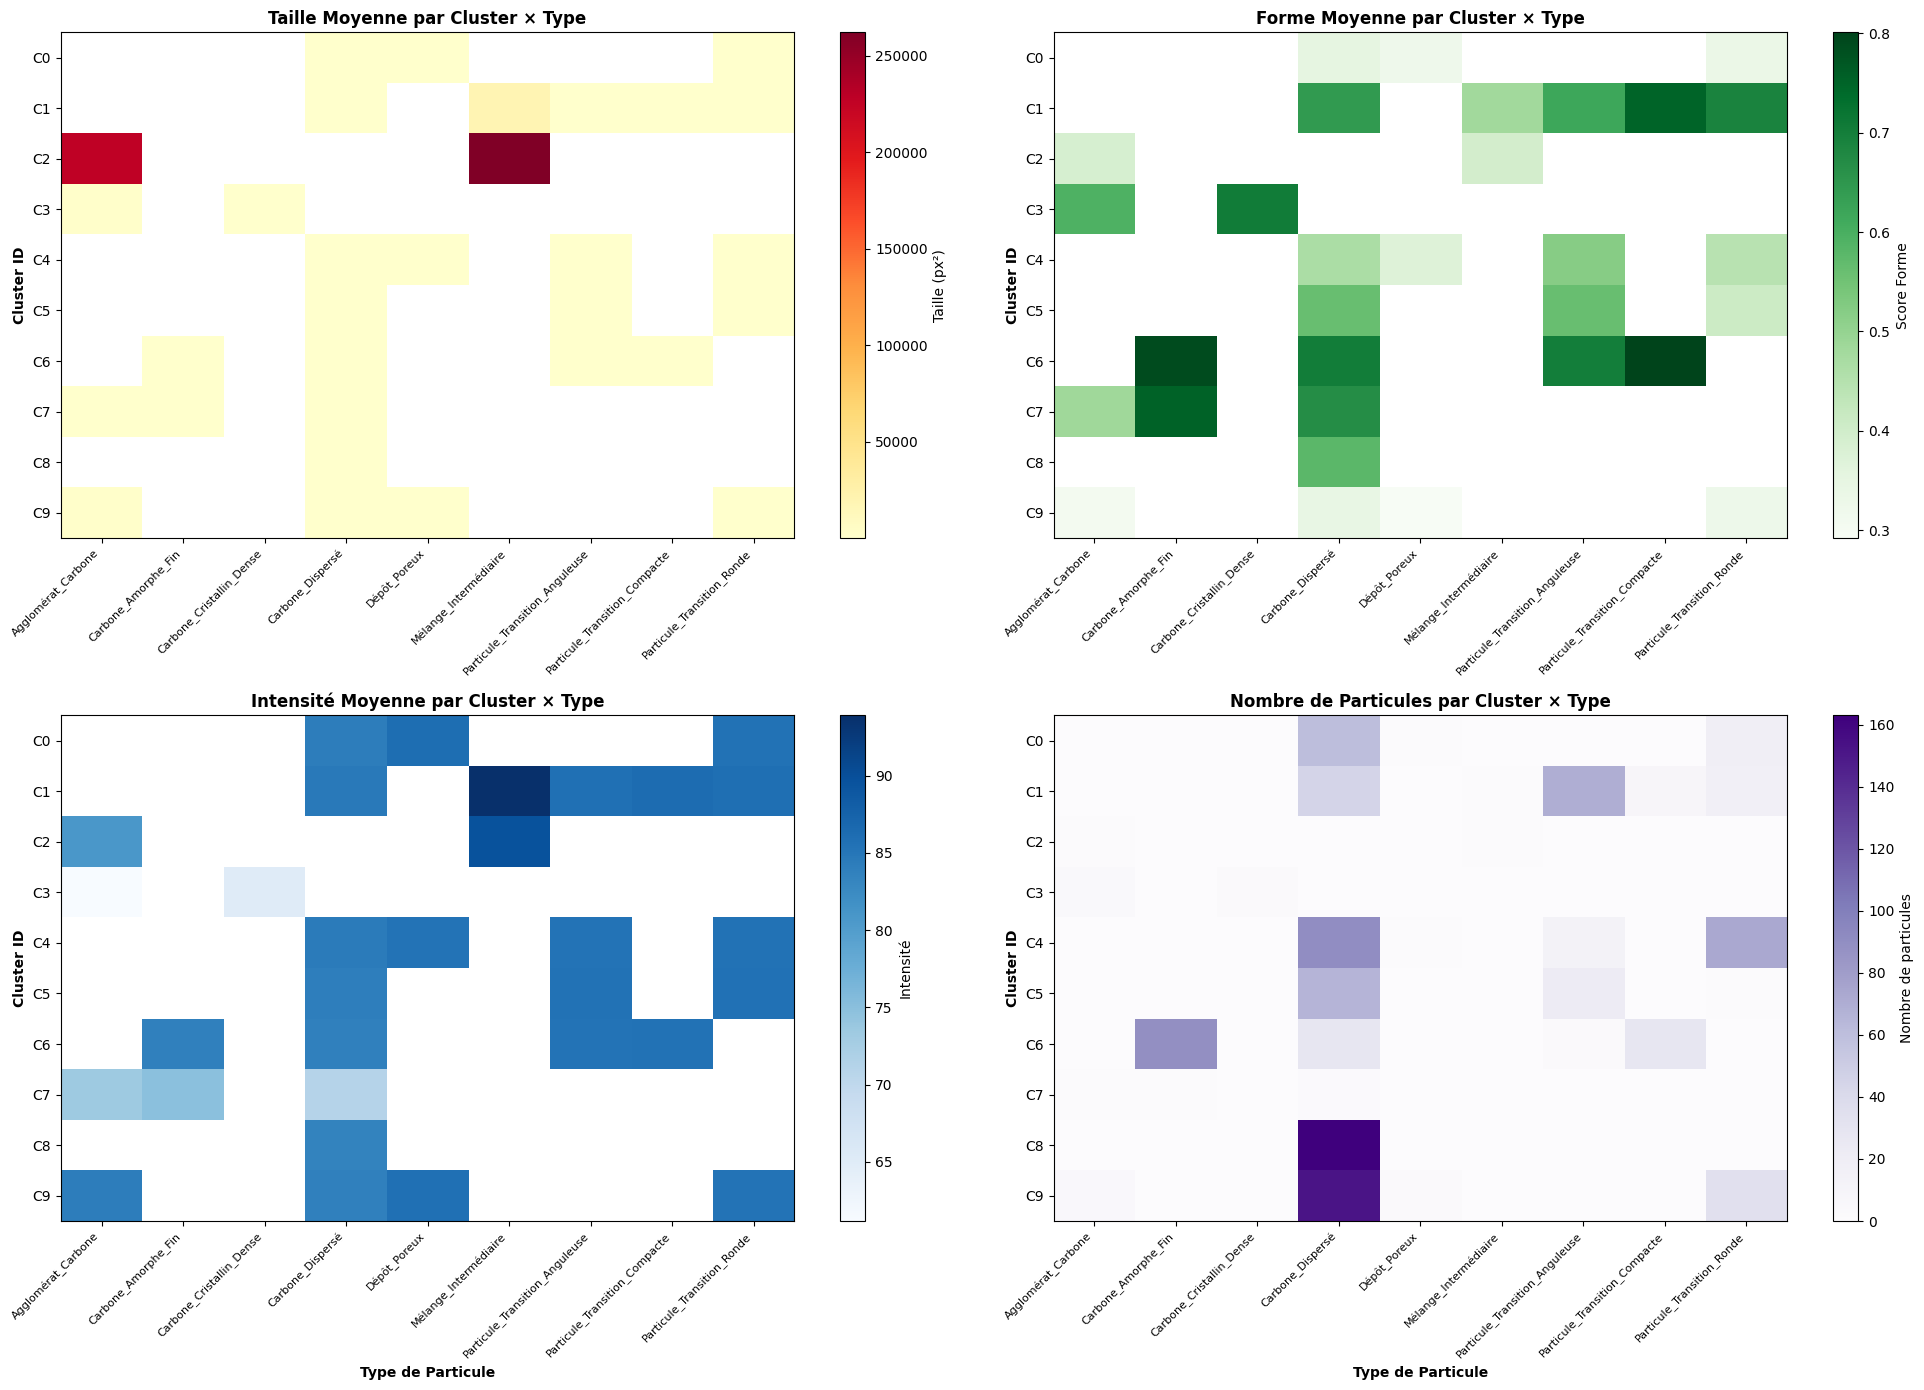


✓ Heatmaps paramétriques générées
✓ Pivots sauvegardés: pivot_*.csv

✓ Analyses pivot complètes


In [29]:
print("\n🔥 GÉNÉRATION DES PIVOTS ET HEATMAPS PARAMÉTRIQUES")
print("="*70)

if 'Cluster_Combined' in df_particles.columns and 'Particle_Type_Combined' in df_particles.columns:
    # Pivots: Cluster × Type
    pivot_size = pd.pivot_table(
        df_particles,
        values='Size_Score',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='mean'
    )
    
    pivot_shape = pd.pivot_table(
        df_particles,
        values='Shape_Score',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='mean'
    )
    
    pivot_intensity = pd.pivot_table(
        df_particles,
        values='Intensity_Score',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='mean'
    )
    
    pivot_count = pd.pivot_table(
        df_particles,
        values='Area_px2',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='count'
    ).fillna(0).astype(int)
    
    # Visualisation des heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    # Heatmap 1: Taille moyenne
    ax = axes[0, 0]
    im1 = ax.imshow(pivot_size.values, cmap='YlOrRd', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_size.columns)))
    ax.set_xticklabels(pivot_size.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_size.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_size.index])
    ax.set_title('Taille Moyenne par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im1, ax=ax, label='Taille (px²)')
    
    # Heatmap 2: Forme moyenne
    ax = axes[0, 1]
    im2 = ax.imshow(pivot_shape.values, cmap='Greens', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_shape.columns)))
    ax.set_xticklabels(pivot_shape.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_shape.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_shape.index])
    ax.set_title('Forme Moyenne par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im2, ax=ax, label='Score Forme')
    
    # Heatmap 3: Intensité moyenne
    ax = axes[1, 0]
    im3 = ax.imshow(pivot_intensity.values, cmap='Blues', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_intensity.columns)))
    ax.set_xticklabels(pivot_intensity.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_intensity.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_intensity.index])
    ax.set_title('Intensité Moyenne par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_xlabel('Type de Particule', fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im3, ax=ax, label='Intensité')
    
    # Heatmap 4: Nombre de particules
    ax = axes[1, 1]
    im4 = ax.imshow(pivot_count.values, cmap='Purples', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_count.columns)))
    ax.set_xticklabels(pivot_count.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_count.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_count.index])
    ax.set_title('Nombre de Particules par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_xlabel('Type de Particule', fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im4, ax=ax, label='Nombre de particules')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Heatmaps paramétriques générées")
    
    # Sauvegarder les pivots
    pivot_size.to_csv("pivot_taille_cluster_type.csv")
    pivot_shape.to_csv("pivot_forme_cluster_type.csv")
    pivot_intensity.to_csv("pivot_intensite_cluster_type.csv")
    pivot_count.to_csv("pivot_count_cluster_type.csv")
    print("✓ Pivots sauvegardés: pivot_*.csv")

print("\n✓ Analyses pivot complètes")

## 7️⃣ Analyse PCA et Réduction Dimensionnelle

In [30]:
print("\n📐 ANALYSE PCA 3D - RÉDUCTION DIMENSIONNELLE")
print("="*70)

# Préparer les données pour PCA
features_for_pca = ['Size_Score', 'Circularity', 'AspectRatio', 'Solidity', 'Intensity_Score', 'Perimeter_px']
X_pca = df_particles[features_for_pca].values

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_pca_scaled)

df_particles['PCA_1'] = X_pca_3d[:, 0]
df_particles['PCA_2'] = X_pca_3d[:, 1]
df_particles['PCA_3'] = X_pca_3d[:, 2]

# Afficher les résultats
print(f"\nVariance expliquée par composante:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var*100:.2f}%")

print(f"\nVariance cumulée:")
cum_var = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(cum_var, 1):
    print(f"  PC1-PC{i}: {var*100:.2f}%")


📐 ANALYSE PCA 3D - RÉDUCTION DIMENSIONNELLE

Variance expliquée par composante:
  PC1: 34.59%
  PC2: 30.63%
  PC3: 17.23%

Variance cumulée:
  PC1-PC1: 34.59%
  PC1-PC2: 65.22%
  PC1-PC3: 82.45%


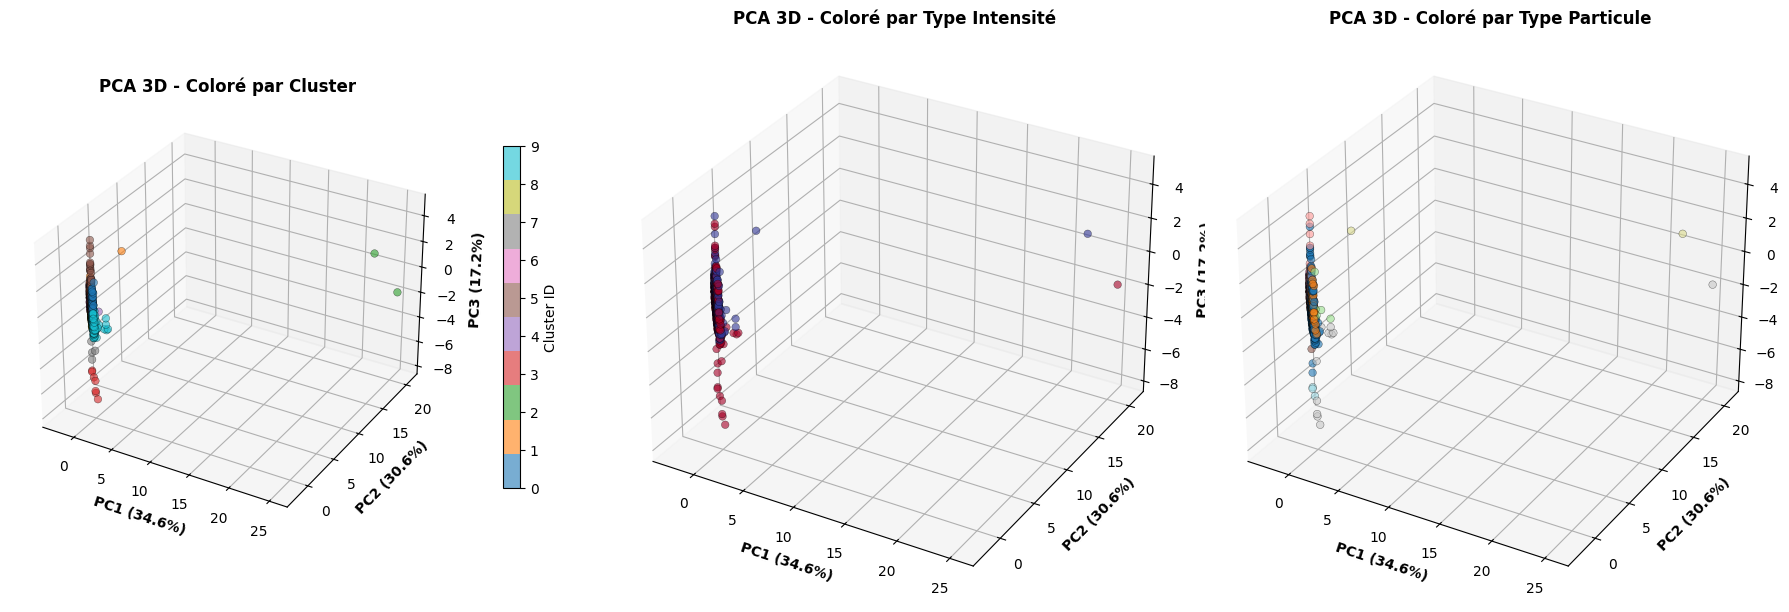


✓ Visualisation PCA 3D générée


In [31]:
# Visualisation 3D PCA
fig = plt.figure(figsize=(18, 6))

# Vue 1: PCA coloré par Cluster_Combined
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(df_particles['PCA_1'], 
                       df_particles['PCA_2'],
                       df_particles['PCA_3'],
                       c=df_particles['Cluster_Combined'], 
                       cmap='tab10', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax1.set_title('PCA 3D - Coloré par Cluster', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster ID', shrink=0.6, pad=0.1)

# Vue 2: PCA coloré par Type d'intensité
ax2 = fig.add_subplot(132, projection='3d')
type_colors = {'Type_1_Blanc': 0, 'Type_2_Gris': 1, 'Type_3_Noir': 2}
color_map = df_particles['Type'].map(type_colors)
scatter2 = ax2.scatter(df_particles['PCA_1'], 
                       df_particles['PCA_2'],
                       df_particles['PCA_3'],
                       c=color_map, 
                       cmap='RdYlBu_r', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_title('PCA 3D - Coloré par Type Intensité', fontsize=12, fontweight='bold')

# Vue 3: PCA coloré par Particle_Type_Combined
ax3 = fig.add_subplot(133, projection='3d')
unique_ptypes = df_particles['Particle_Type_Combined'].unique()
ptype_to_num = {t: i for i, t in enumerate(unique_ptypes)}
color_map_ptype = df_particles['Particle_Type_Combined'].map(ptype_to_num)
scatter3 = ax3.scatter(df_particles['PCA_1'], 
                       df_particles['PCA_2'],
                       df_particles['PCA_3'],
                       c=color_map_ptype, 
                       cmap='tab20', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax3.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax3.set_title('PCA 3D - Coloré par Type Particule', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualisation PCA 3D générée")

## 8️⃣ Identification de la Zone Équilibrée Représentative

In [32]:
# Import pour la distance de Wasserstein
from scipy.stats import wasserstein_distance

print("\n🏆 IDENTIFICATION DE LA ZONE ÉQUILIBRÉE REPRÉSENTATIVE")
print("="*80)

# Calculer la distribution globale
total_clusters = df_particles['Cluster_Combined'].nunique()
global_cluster_counts = df_particles['Cluster_Combined'].value_counts().sort_index()
global_cluster_distribution = (global_cluster_counts / len(df_particles)).values

print(f"\n📊 Distribution GLOBALE des {total_clusters} clusters:")
for cluster_id, count in global_cluster_counts.items():
    pct = 100 * count / len(df_particles)
    print(f"  Cluster {cluster_id}: {count} particules ({pct:.1f}%)")

# Balayage systématique
print(f"\n🔍 Recherche de la zone la plus équilibrée avec TOUS les {total_clusters} clusters...")

window_sizes = [300, 400, 500, 600, 700, 800]
step_size = 50

img_height, img_width = img_rgb.shape[:2]
best_score_overall = -np.inf
best_window = None
candidates = []

for window_size in window_sizes:
    print(f"  Balayage avec fenêtre {window_size}x{window_size} pixels...")
    
    for y in range(0, img_height - window_size, step_size):
        for x in range(0, img_width - window_size, step_size):
            x_min, x_max = x, x + window_size
            y_min, y_max = y, y + window_size
            
            in_window = ((df_particles['Center_X'] >= x_min) & 
                        (df_particles['Center_X'] <= x_max) &
                        (df_particles['Center_Y'] >= y_min) & 
                        (df_particles['Center_Y'] <= y_max))
            
            particles_in_window = df_particles[in_window]
            
            if len(particles_in_window) < total_clusters * 2:
                continue
            
            unique_clusters_in_window = particles_in_window['Cluster_Combined'].nunique()
            
            if unique_clusters_in_window == total_clusters:
                local_cluster_counts = particles_in_window['Cluster_Combined'].value_counts().sort_index()
                
                if len(local_cluster_counts) == total_clusters:
                    local_cluster_distribution = (local_cluster_counts / len(particles_in_window)).values
                    
                    wasserstein_dist = wasserstein_distance(global_cluster_distribution, 
                                                            local_cluster_distribution)
                    
                    max_entropy = -np.log(1.0 / total_clusters)
                    actual_entropy = entropy(local_cluster_distribution)
                    balance_score = actual_entropy / max_entropy
                    
                    min_count_in_cluster = local_cluster_counts.min()
                    min_proportion_penalty = np.exp(-5.0 / (min_count_in_cluster + 1))
                    
                    similarity_score = 1.0 / (1.0 + wasserstein_dist)
                    combined_score = (similarity_score * 0.3 + 
                                    balance_score * 0.5 + 
                                    (1.0 - min_proportion_penalty) * 0.2)
                    
                    candidates.append({
                        'score': combined_score,
                        'x': x,
                        'y': y,
                        'size': window_size,
                        'n_particles': len(particles_in_window),
                        'distribution': local_cluster_counts.to_dict()
                    })
                    
                    if combined_score > best_score_overall:
                        best_score_overall = combined_score
                        best_window = {
                            'x': x,
                            'y': y,
                            'size': window_size,
                            'n_particles': len(particles_in_window),
                            'distribution': local_cluster_counts.to_dict()
                        }

candidates.sort(key=lambda c: c['score'], reverse=True)

print(f"\n✅ Balayage terminé: {len(candidates)} zones avec TOUS les clusters trouvées")

# Si aucune zone trouvée, utiliser l'image complète
if best_window is None:
    print("\n⚠️  ATTENTION: Aucune région ne contient tous les clusters!")
    print("   Élargissement de la recherche avec fenêtres plus grandes...")
    
    # Élargir la recherche avec de très grandes fenêtres
    large_window_sizes = [1000, 1200, 1500, 2000]
    for window_size in large_window_sizes:
        if window_size > min(img_height, img_width):
            continue
            
        print(f"  Tentative avec fenêtre {window_size}x{window_size}...")
        
        for y in range(0, img_height - window_size, 100):
            for x in range(0, img_width - window_size, 100):
                x_min, x_max = x, x + window_size
                y_min, y_max = y, y + window_size
                
                in_window = ((df_particles['Center_X'] >= x_min) & 
                            (df_particles['Center_X'] <= x_max) &
                            (df_particles['Center_Y'] >= y_min) & 
                            (df_particles['Center_Y'] <= y_max))
                
                particles_in_window = df_particles[in_window]
                unique_clusters = particles_in_window['Cluster_Combined'].nunique()
                
                if unique_clusters == total_clusters:
                    best_window = {
                        'x': x, 'y': y, 'size': window_size,
                        'n_particles': len(particles_in_window),
                        'distribution': particles_in_window['Cluster_Combined'].value_counts().to_dict()
                    }
                    print(f"    ✓ Zone trouvée!")
                    break
            if best_window:
                break
        if best_window:
            break
    
    if best_window is None:
        # Dernier recours: prendre toute l'image
        print("\n⚠️  Utilisation de l'image complète comme échantillon")
        best_window = {
            'x': 0, 'y': 0,
            'size': min(img_height, img_width),
            'n_particles': len(df_particles),
            'distribution': df_particles['Cluster_Combined'].value_counts().to_dict()
        }

# Variables pour la suite
best_sample_idx = 0  # Pour compatibilité
x_center = best_window['x'] + best_window['size'] // 2
y_center = best_window['y'] + best_window['size'] // 2
square_size = best_window['size']
x_topleft = best_window['x']
y_topleft = best_window['y']

# Afficher les résultats de la meilleure zone
print(f"\n✅ Meilleure zone équilibrée identifiée:")
print(f"  • Position: ({x_center:.0f}, {y_center:.0f})")
print(f"  • Taille de la fenêtre: {square_size}x{square_size} pixels")
print(f"  • Nombre de particules: {best_window['n_particles']}")

if 'wasserstein' in best_window:
    print(f"  • Distance de Wasserstein: {best_window['wasserstein']:.4f}")
    print(f"  • Score d'équilibre (entropie): {best_window['balance']:.4f}")
    print(f"  • Minimum particules/cluster: {best_window['min_count']}")
    print(f"  • Score combiné: {best_score_overall:.4f}")

print(f"\n📊 Distribution dans la zone équilibrée ({best_window['n_particles']} particules):")
print(f"  TOUS LES {total_clusters} CLUSTERS SONT PRÉSENTS ✓\n")

# Vérifier la distribution détaillée
in_best_window = ((df_particles['Center_X'] >= x_topleft) & 
                  (df_particles['Center_X'] <= x_topleft + square_size) &
                  (df_particles['Center_Y'] >= y_topleft) & 
                  (df_particles['Center_Y'] <= y_topleft + square_size))
particles_in_best = df_particles[in_best_window]
region_cluster_counts = particles_in_best['Cluster_Combined'].value_counts().sort_index()

for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
    if cluster_id in region_cluster_counts.index:
        region_count = region_cluster_counts[cluster_id]
        region_pct = 100 * region_count / len(particles_in_best)
        global_pct = 100 * global_cluster_counts[cluster_id] / len(df_particles)
        diff = region_pct - global_pct
        
        # Indicateur visuel d'équilibre
        if abs(diff) < 2.0:
            indicator = "✓✓"  # Très bien équilibré
        elif abs(diff) < 5.0:
            indicator = "✓"   # Bien équilibré
        else:
            indicator = "~"   # Acceptable
        
        print(f"  {indicator} Cluster {cluster_id}: {region_count:3d} particules ({region_pct:5.1f}%) vs {global_pct:5.1f}% global [Δ {diff:+5.1f}%]")
    else:
        # Cela ne devrait jamais arriver maintenant
        global_pct = 100 * global_cluster_counts[cluster_id] / len(df_particles)
        print(f"  ✗ Cluster {cluster_id}: ABSENT (vs {global_pct:5.1f}% global)")

# Afficher les top candidats alternatifs
if len(candidates) > 1:
    print(f"\n🏅 Top 5 zones équilibrées trouvées:")
    for i, candidate in enumerate(candidates[:5], 1):
        print(f"  {i}. Score={candidate['score']:.4f} | Pos=({candidate['x']}, {candidate['y']}) | "
              f"Taille={candidate['size']}px | Particules={candidate['n_particles']}")

# Sauvegarder info sur la zone équilibrée
zone_info = {
    'Center_X': x_center,
    'Center_Y': y_center,
    'TopLeft_X': x_topleft,
    'TopLeft_Y': y_topleft,
    'Window_Size': square_size,
    'Total_Particles': best_window['n_particles'],
    'Total_Clusters_Present': total_clusters,
    'Score': best_score_overall if best_score_overall != -np.inf else 0.0
}

# Ajouter les distributions de clusters
for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
    count = region_cluster_counts.get(cluster_id, 0)
    zone_info[f'Cluster_{cluster_id}_Count'] = count
    zone_info[f'Cluster_{cluster_id}_Pct'] = 100 * count / best_window['n_particles']

zone_info_df = pd.DataFrame([zone_info])
zone_info_df.to_csv("zone_equilibree_info.csv", index=False)
print("\n✓ Informations de la zone équilibrée sauvegardées: zone_equilibree_info.csv")


🏆 IDENTIFICATION DE LA ZONE ÉQUILIBRÉE REPRÉSENTATIVE

📊 Distribution GLOBALE des 10 clusters:
  Cluster 0: 80 particules (8.0%)
  Cluster 1: 141 particules (14.0%)
  Cluster 2: 2 particules (0.2%)
  Cluster 3: 7 particules (0.7%)
  Cluster 4: 177 particules (17.6%)
  Cluster 5: 89 particules (8.9%)
  Cluster 6: 148 particules (14.7%)
  Cluster 7: 4 particules (0.4%)
  Cluster 8: 163 particules (16.2%)
  Cluster 9: 194 particules (19.3%)

🔍 Recherche de la zone la plus équilibrée avec TOUS les 10 clusters...
  Balayage avec fenêtre 300x300 pixels...
  Balayage avec fenêtre 400x400 pixels...
  Balayage avec fenêtre 500x500 pixels...
  Balayage avec fenêtre 600x600 pixels...
  Balayage avec fenêtre 700x700 pixels...
  Balayage avec fenêtre 800x800 pixels...

✅ Balayage terminé: 115 zones avec TOUS les clusters trouvées

✅ Meilleure zone équilibrée identifiée:
  • Position: (350, 300)
  • Taille de la fenêtre: 300x300 pixels
  • Nombre de particules: 127

📊 Distribution dans la zone équi

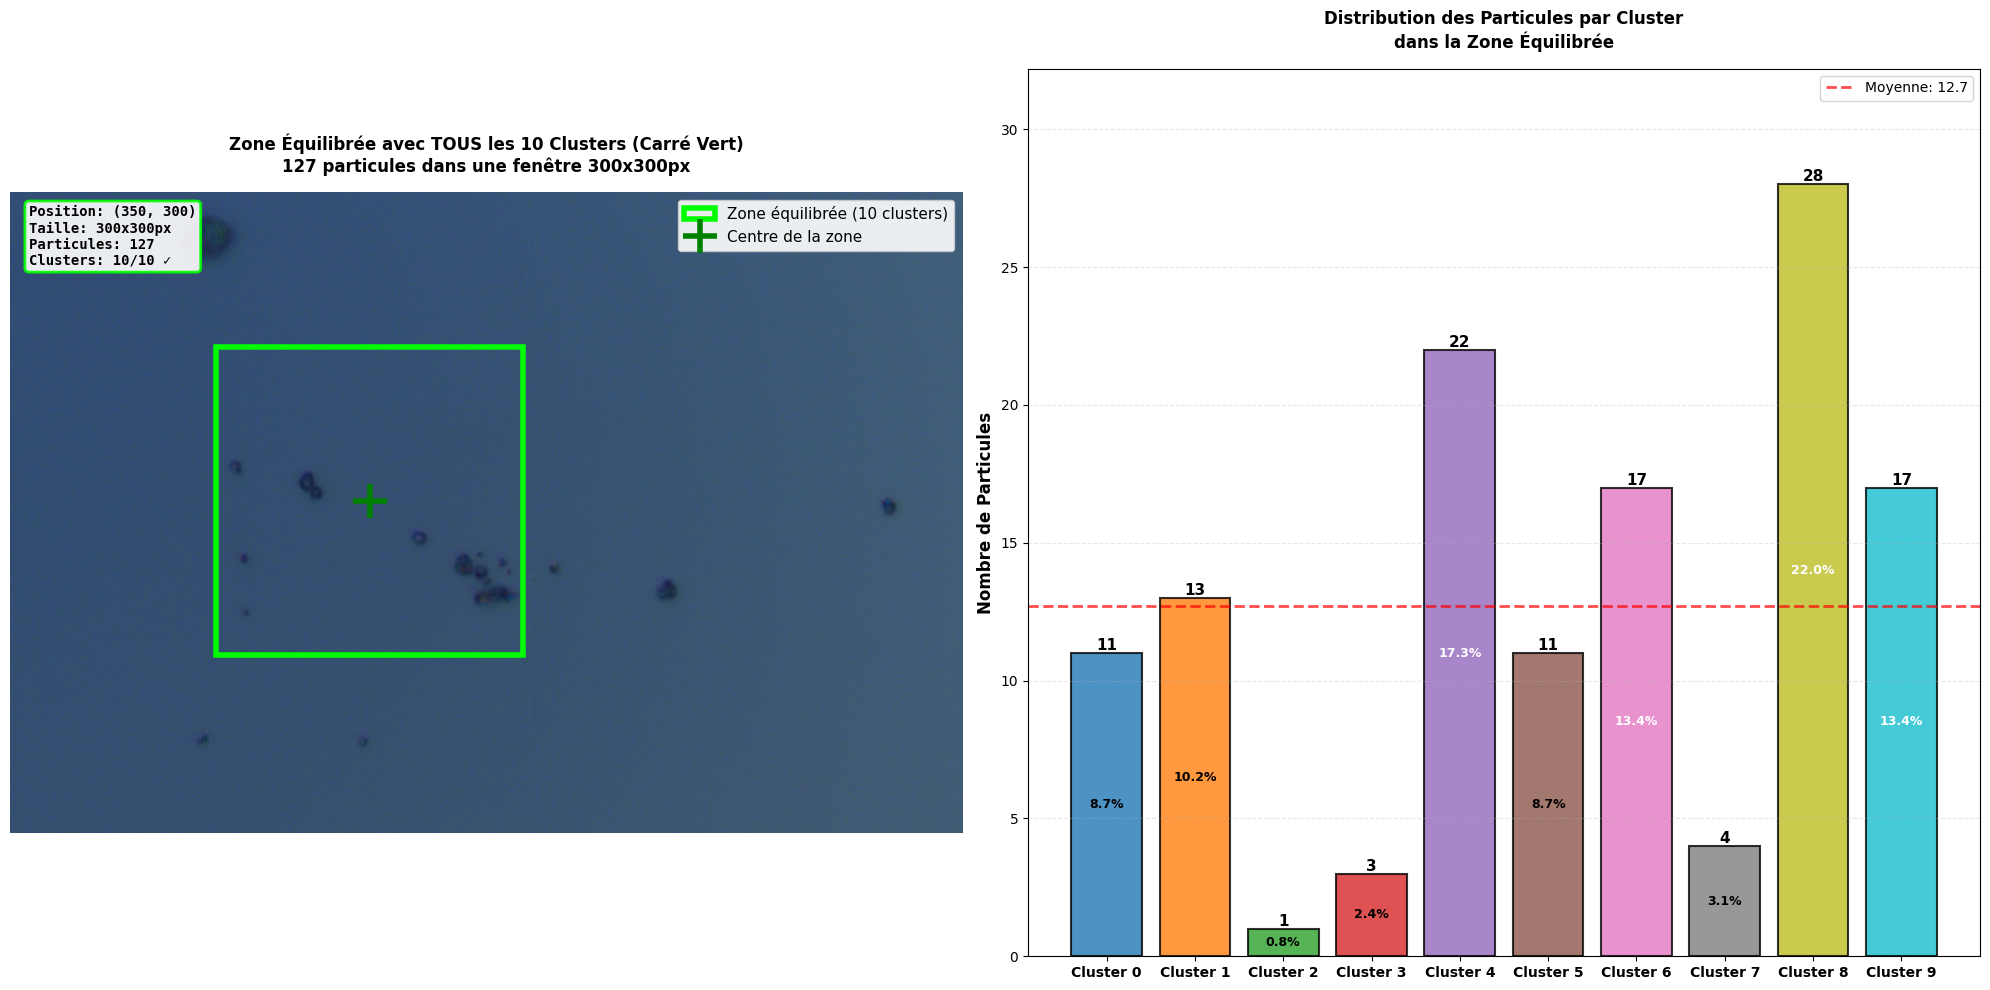


✓ Zone équilibrée visualisée avec distribution des clusters

📊 TABLEAU RÉCAPITULATIF - PARTICULES PAR CLUSTER DANS LA ZONE

Cluster    Quantité     % Zone       % Global     Écart     
--------------------------------------------------------------------------------
Cluster 0  11             8.66%        7.96%       +0.70%
Cluster 1  13            10.24%       14.03%       -3.79%
Cluster 2  1              0.79%        0.20%       +0.59%
Cluster 3  3              2.36%        0.70%       +1.67%
Cluster 4  22            17.32%       17.61%       -0.29%
Cluster 5  11             8.66%        8.86%       -0.19%
Cluster 6  17            13.39%       14.73%       -1.34%
Cluster 7  4              3.15%        0.40%       +2.75%
Cluster 8  28            22.05%       16.22%       +5.83%
Cluster 9  17            13.39%       19.30%       -5.92%
--------------------------------------------------------------------------------
TOTAL      127          100.00%     
✓ Informations du meilleur échantil

In [33]:
# Visualisation avec carré vert et distribution des clusters
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# GRAPHIQUE 1: Image avec carré vert
ax = axes[0]
ax.imshow(img_rgb)
ax.set_title(f'Zone Équilibrée avec TOUS les {total_clusters} Clusters (Carré Vert)\n' + 
            f'{best_window["n_particles"]} particules dans une fenêtre {square_size}x{square_size}px', 
            fontsize=12, fontweight='bold', pad=15)
ax.axis('off')

green_square = Rectangle((x_topleft, y_topleft), square_size, square_size, 
                         linewidth=4, edgecolor='lime', facecolor='none', 
                         label=f'Zone équilibrée ({total_clusters} clusters)')
ax.add_patch(green_square)

ax.plot(x_center, y_center, 'g+', markersize=25, markeredgewidth=4, 
       label='Centre de la zone')

text_info = f"Position: ({x_center:.0f}, {y_center:.0f})\n"
text_info += f"Taille: {square_size}x{square_size}px\n"
text_info += f"Particules: {best_window['n_particles']}\n"
text_info += f"Clusters: {total_clusters}/{total_clusters} ✓"

ax.text(0.02, 0.98, text_info, transform=ax.transAxes, 
       fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='lime', linewidth=2),
       fontweight='bold', family='monospace')

ax.legend(loc='upper right', fontsize=11, framealpha=0.9)

# GRAPHIQUE 2: Distribution des clusters
ax2 = axes[1]

cluster_ids = sorted(df_particles['Cluster_Combined'].unique())
cluster_counts_in_zone = [region_cluster_counts.get(cid, 0) for cid in cluster_ids]

colors_clusters = plt.cm.tab10(np.linspace(0, 1, len(cluster_ids)))
bars = ax2.bar(range(len(cluster_ids)), cluster_counts_in_zone, 
               color=colors_clusters, edgecolor='black', linewidth=1.5, alpha=0.8)

ax2.set_xticks(range(len(cluster_ids)))
ax2.set_xticklabels([f'Cluster {cid}' for cid in cluster_ids], fontsize=10, fontweight='bold')
ax2.set_ylabel('Nombre de Particules', fontsize=12, fontweight='bold')
ax2.set_title(f'Distribution des Particules par Cluster\ndans la Zone Équilibrée', 
             fontsize=12, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (count, bar) in enumerate(zip(cluster_counts_in_zone, bars)):
    pct = 100 * count / best_window['n_particles']
    height = bar.get_height()
    
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.text(bar.get_x() + bar.get_width()/2., height/2,
            f'{pct:.1f}%',
            ha='center', va='center', fontsize=9, fontweight='bold',
            color='white' if count > max(cluster_counts_in_zone)/2 else 'black')

mean_count = np.mean(cluster_counts_in_zone)
ax2.axhline(y=mean_count, color='red', linestyle='--', linewidth=2, 
           label=f'Moyenne: {mean_count:.1f}', alpha=0.7)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim(0, max(cluster_counts_in_zone) * 1.15)

plt.tight_layout()
plt.show()

print("\n✓ Zone équilibrée visualisée avec distribution des clusters")

# Afficher aussi un tableau récapitulatif dans la console
print("\n" + "="*80)
print("📊 TABLEAU RÉCAPITULATIF - PARTICULES PAR CLUSTER DANS LA ZONE")
print("="*80)
print(f"\n{'Cluster':<10} {'Quantité':<12} {'% Zone':<12} {'% Global':<12} {'Écart':<10}")
print("-" * 80)

for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
    count = region_cluster_counts.get(cluster_id, 0)
    pct_zone = 100 * count / best_window['n_particles']
    pct_global = 100 * global_cluster_counts[cluster_id] / len(df_particles)
    ecart = pct_zone - pct_global
    
    print(f"Cluster {cluster_id:<2} {count:<12} {pct_zone:>6.2f}%{'':<5} {pct_global:>6.2f}%{'':<5} {ecart:>+6.2f}%")

print("-" * 80)
print(f"{'TOTAL':<10} {best_window['n_particles']:<12} {'100.00%':<12}")
print("="*80)

# Sauvegarder les informations de l'échantillon (pour compatibilité)
best_sample_info = {
    'Center_X': x_center,
    'Center_Y': y_center,
    'Total_Clusters': total_clusters,
    'Total_Particles_In_Zone': best_window['n_particles'],
    'Window_Size_px': square_size,
    'TopLeft_X': x_topleft,
    'TopLeft_Y': y_topleft,
    'All_Clusters_Present': 'YES',
    'Score': best_score_overall if best_score_overall != -np.inf else 0.0
}

best_sample_df = pd.DataFrame([best_sample_info])
best_sample_df.to_csv("best_representative_sample.csv", index=False)
print("✓ Informations du meilleur échantillon sauvegardées: best_representative_sample.csv")

print("\n" + "="*80)
print("✅ IDENTIFICATION DE LA ZONE ÉQUILIBRÉE TERMINÉE!")
print("="*80)

## 9️⃣ Visualisations Avancées et Heatmaps


📊 Génération des scatter plots multi-niveaux...



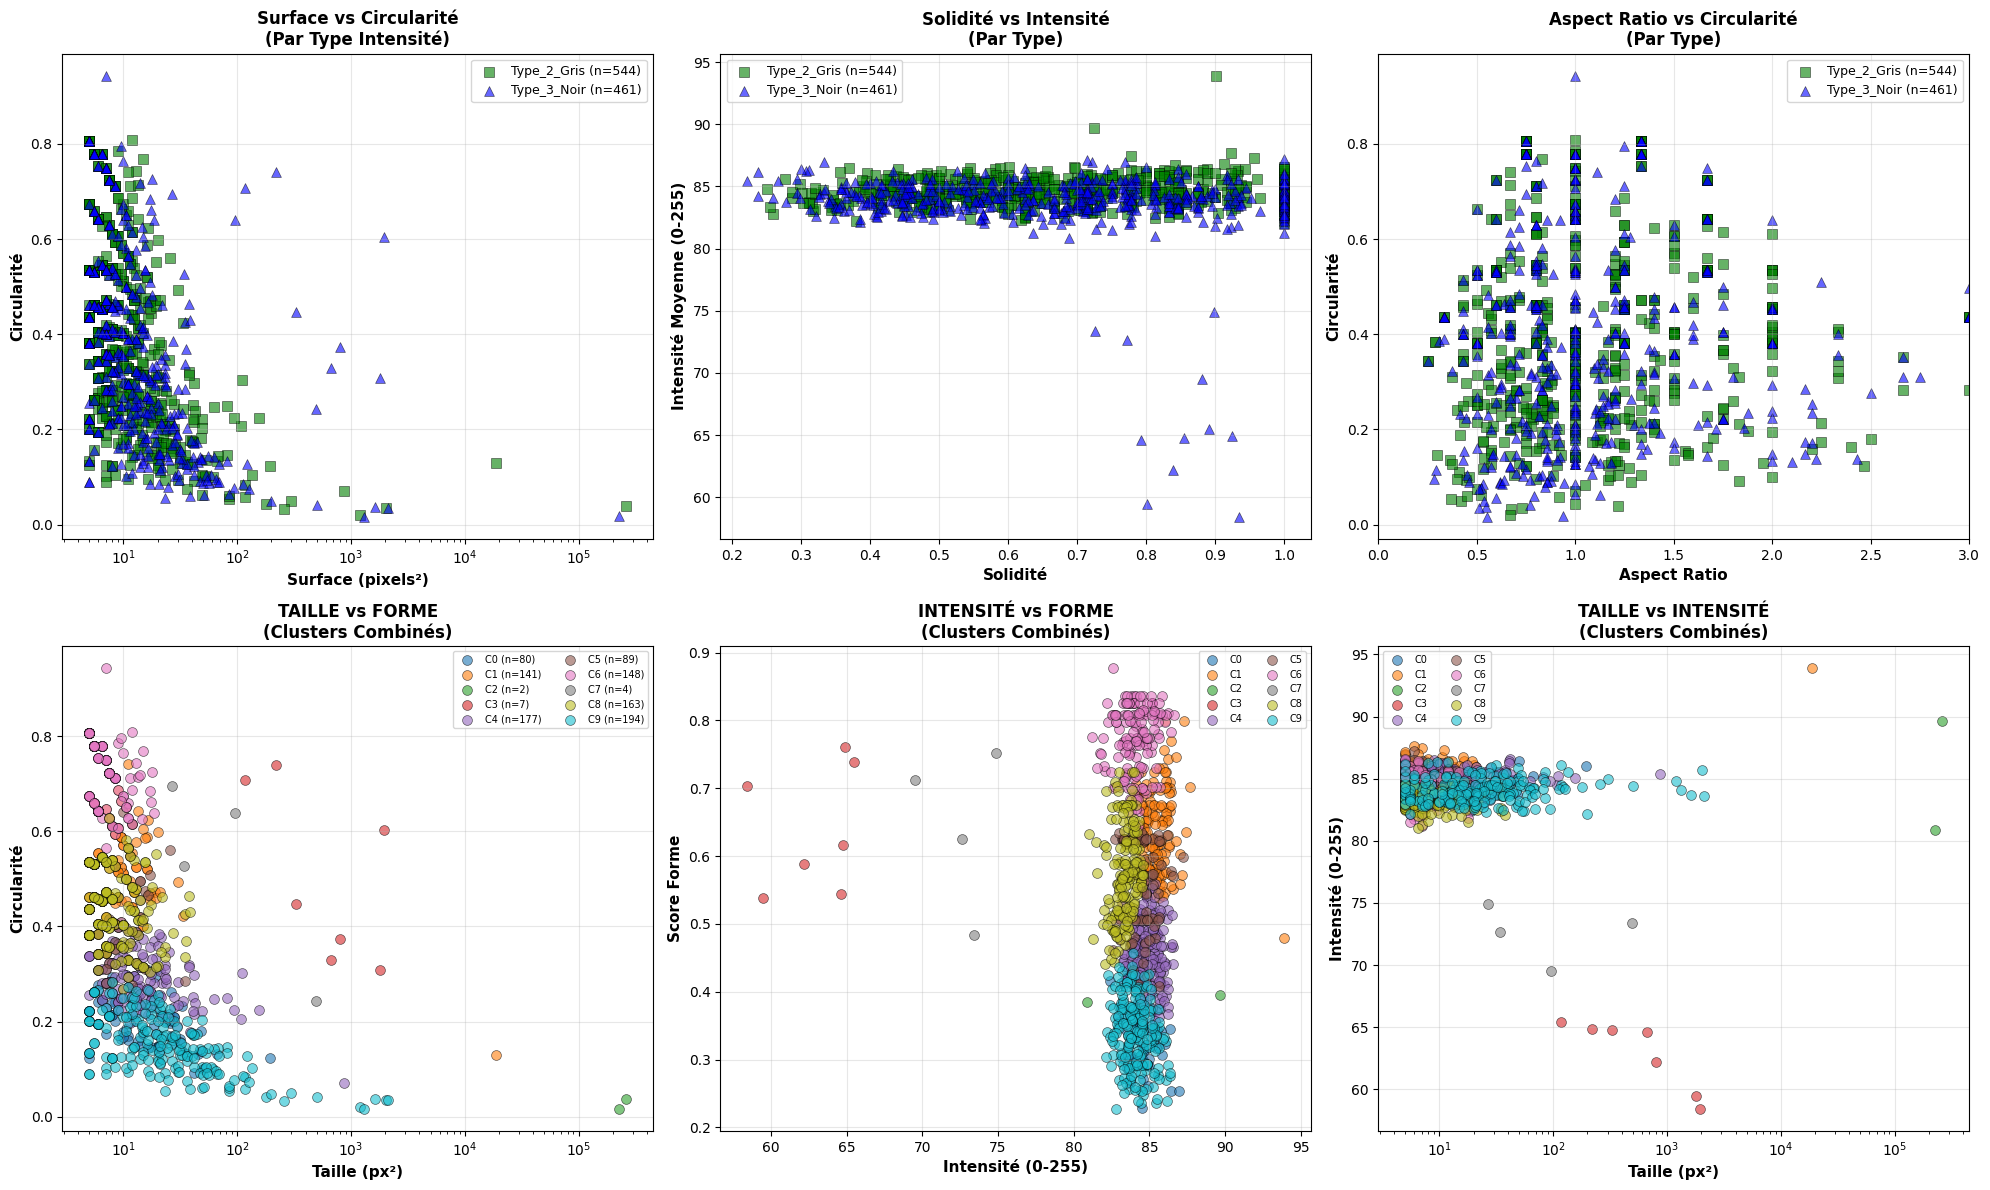

✓ Scatter plots générés


In [34]:
# Scatter plots multi-niveaux
print("\n📊 Génération des scatter plots multi-niveaux...\n")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: Vue par type d'intensité
ax = axes[0, 0]
for type_name, color, marker in [('Type_1_Blanc', 'red', 'o'), 
                                   ('Type_2_Gris', 'green', 's'), 
                                   ('Type_3_Noir', 'blue', '^')]:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        ax.scatter(df_type['Area_px2'], df_type['Circularity'], 
                  c=color, marker=marker, s=50, alpha=0.6, 
                  edgecolors='black', linewidth=0.5,
                  label=f'{type_name} (n={len(df_type)})')

ax.set_xlabel('Surface (pixels²)', fontsize=11, fontweight='bold')
ax.set_ylabel('Circularité', fontsize=11, fontweight='bold')
ax.set_title('Surface vs Circularité\n(Par Type Intensité)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Row 1, Col 2: Solidité vs Intensité
ax = axes[0, 1]
for type_name, color, marker in [('Type_1_Blanc', 'red', 'o'), 
                                   ('Type_2_Gris', 'green', 's'), 
                                   ('Type_3_Noir', 'blue', '^')]:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        ax.scatter(df_type['Solidity'], df_type['MeanIntensity'], 
                  c=color, marker=marker, s=50, alpha=0.6, 
                  edgecolors='black', linewidth=0.5,
                  label=f'{type_name} (n={len(df_type)})')

ax.set_xlabel('Solidité', fontsize=11, fontweight='bold')
ax.set_ylabel('Intensité Moyenne (0-255)', fontsize=11, fontweight='bold')
ax.set_title('Solidité vs Intensité\n(Par Type)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Row 1, Col 3: AspectRatio vs Circularité
ax = axes[0, 2]
for type_name, color, marker in [('Type_1_Blanc', 'red', 'o'), 
                                   ('Type_2_Gris', 'green', 's'), 
                                   ('Type_3_Noir', 'blue', '^')]:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        ax.scatter(df_type['AspectRatio'], df_type['Circularity'], 
                  c=color, marker=marker, s=50, alpha=0.6, 
                  edgecolors='black', linewidth=0.5,
                  label=f'{type_name} (n={len(df_type)})')

ax.set_xlabel('Aspect Ratio', fontsize=11, fontweight='bold')
ax.set_ylabel('Circularité', fontsize=11, fontweight='bold')
ax.set_title('Aspect Ratio vs Circularité\n(Par Type)', fontsize=12, fontweight='bold')
ax.set_xlim(0, min(5, df_particles['AspectRatio'].quantile(0.99)))
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Row 2: Par clusters
if 'Cluster_Combined' in df_particles.columns:
    n_clusters = df_particles['Cluster_Combined'].nunique()
    colors_clusters = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    # Taille vs Circularité
    ax = axes[1, 0]
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        df_cluster = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        ax.scatter(df_cluster['Size_Score'], df_cluster['Circularity'],
                  c=[colors_clusters[cluster_id]], s=50, alpha=0.6,
                  edgecolors='black', linewidth=0.5,
                  label=f'C{cluster_id} (n={len(df_cluster)})')
    
    ax.set_xlabel('Taille (px²)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Circularité', fontsize=11, fontweight='bold')
    ax.set_title('TAILLE vs FORME\n(Clusters Combinés)', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Intensité vs Shape
    ax = axes[1, 1]
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        df_cluster = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        ax.scatter(df_cluster['Intensity_Score'], df_cluster['Shape_Score'],
                  c=[colors_clusters[cluster_id]], s=50, alpha=0.6,
                  edgecolors='black', linewidth=0.5,
                  label=f'C{cluster_id}')
    
    ax.set_xlabel('Intensité (0-255)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score Forme', fontsize=11, fontweight='bold')
    ax.set_title('INTENSITÉ vs FORME\n(Clusters Combinés)', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Taille vs Intensité
    ax = axes[1, 2]
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        df_cluster = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        ax.scatter(df_cluster['Size_Score'], df_cluster['Intensity_Score'],
                  c=[colors_clusters[cluster_id]], s=50, alpha=0.6,
                  edgecolors='black', linewidth=0.5,
                  label=f'C{cluster_id}')
    
    ax.set_xlabel('Taille (px²)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Intensité (0-255)', fontsize=11, fontweight='bold')
    ax.set_title('TAILLE vs INTENSITÉ\n(Clusters Combinés)', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Scatter plots générés")


🔥 Génération des heatmaps...



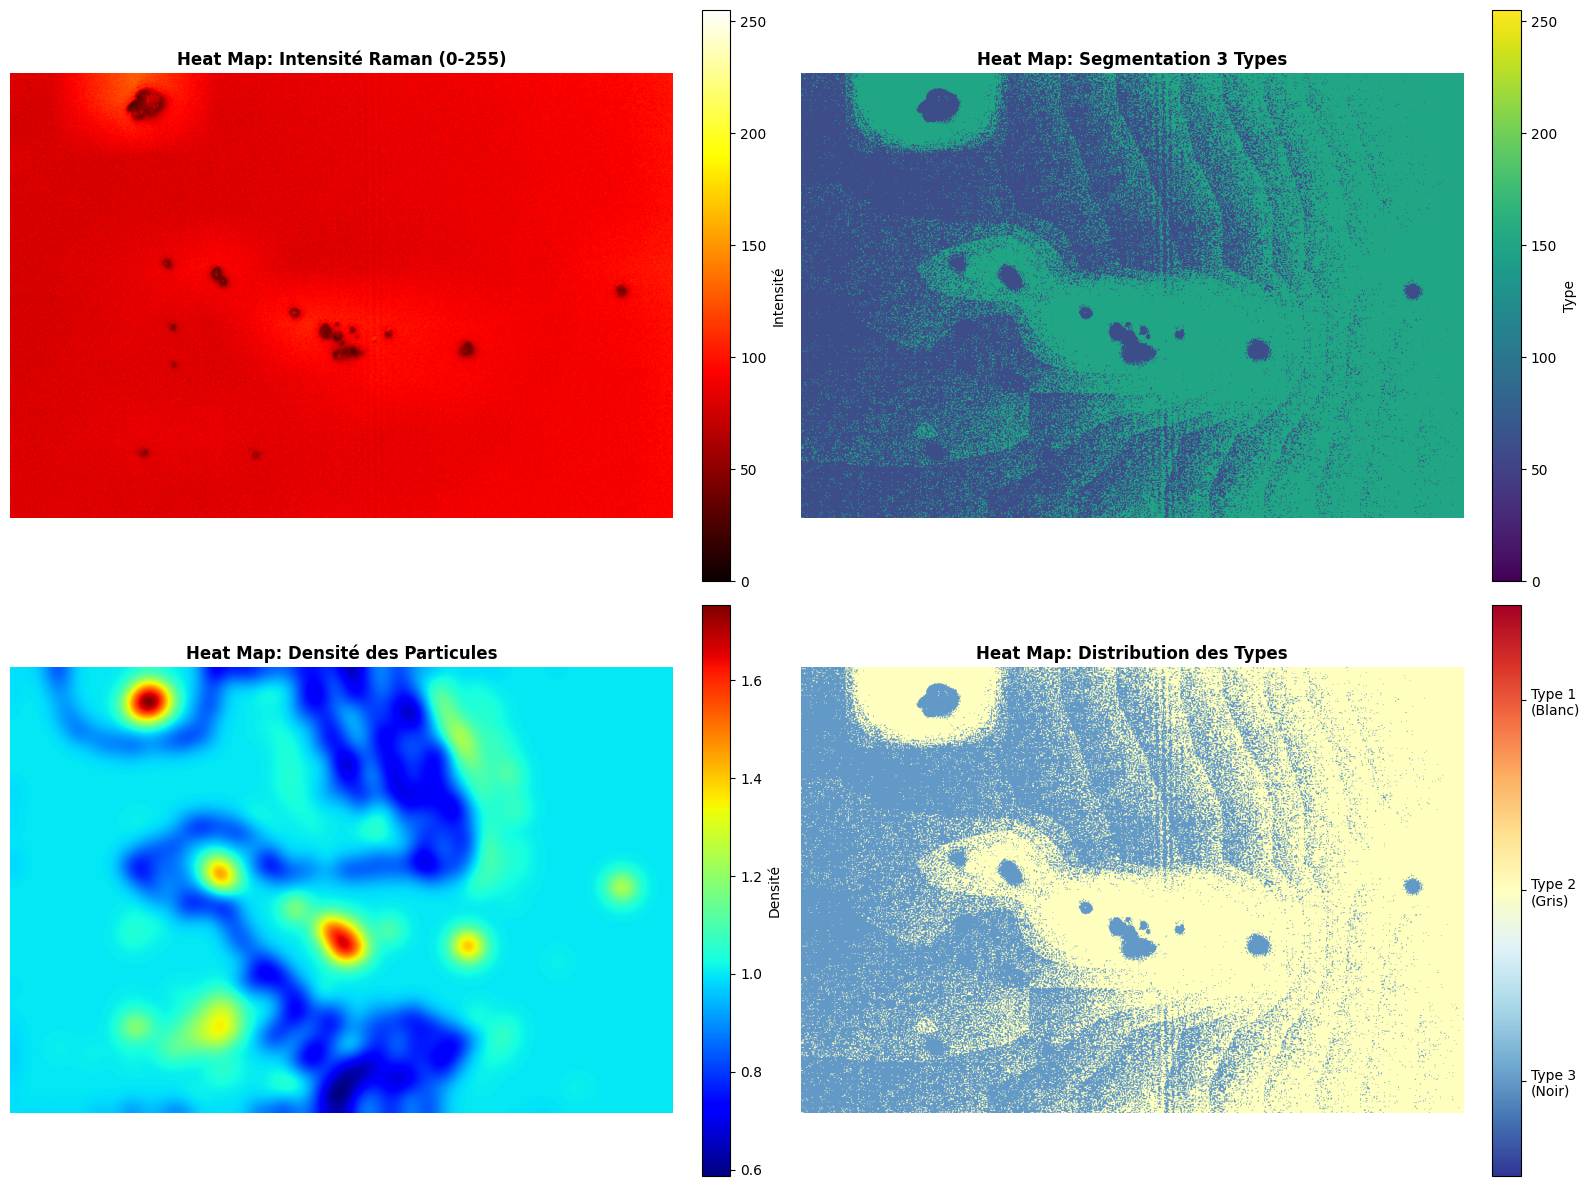

✓ Heat maps générées avec succès!


In [35]:
# Heat maps
print("\n🔥 Génération des heatmaps...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap 1: Intensité Raman
ax = axes[0, 0]
im1 = ax.imshow(gray_eq, cmap='hot', vmin=0, vmax=255)
ax.set_title('Heat Map: Intensité Raman (0-255)', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04, label='Intensité')

# Heatmap 2: Segmentation
ax = axes[0, 1]
im2 = ax.imshow(segmentation_img, cmap='viridis', vmin=0, vmax=255)
ax.set_title('Heat Map: Segmentation 3 Types', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='Type')

# Heatmap 3: Densité
ax = axes[1, 0]
density_map = np.zeros_like(gray_eq, dtype=np.float32)
for contours_list in [contours_type1, contours_type2, contours_type3]:
    for cnt in contours_list:
        mask_temp = np.zeros_like(gray_eq, dtype=np.uint8)
        cv2.drawContours(mask_temp, [cnt], -1, 1, -1)
        density_map += mask_temp

density_smooth = gaussian_filter(density_map, sigma=15)
im3 = ax.imshow(density_smooth, cmap='jet', interpolation='bilinear')
ax.set_title('Heat Map: Densité des Particules', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='Densité')

# Heatmap 4: Distribution types
ax = axes[1, 1]
composite_map = np.zeros_like(gray_eq, dtype=np.float32)
composite_map[mask_type3] = 1.0
composite_map[mask_type2] = 2.0
composite_map[mask_type1] = 3.0

im4 = ax.imshow(composite_map, cmap='RdYlBu_r', vmin=0.5, vmax=3.5)
ax.set_title('Heat Map: Distribution des Types', fontsize=12, fontweight='bold')
ax.axis('off')
cbar4 = plt.colorbar(im4, ax=ax, fraction=0.046, pad=0.04, ticks=[1, 2, 3])
cbar4.ax.set_yticklabels(['Type 3\n(Noir)', 'Type 2\n(Gris)', 'Type 1\n(Blanc)'])

plt.tight_layout()
plt.show()

print("✓ Heat maps générées avec succès!")

## 9️⃣.1 Visualisation 3D des 3 Paramètres Combinés


📐 Génération de la visualisation 3D combinée...


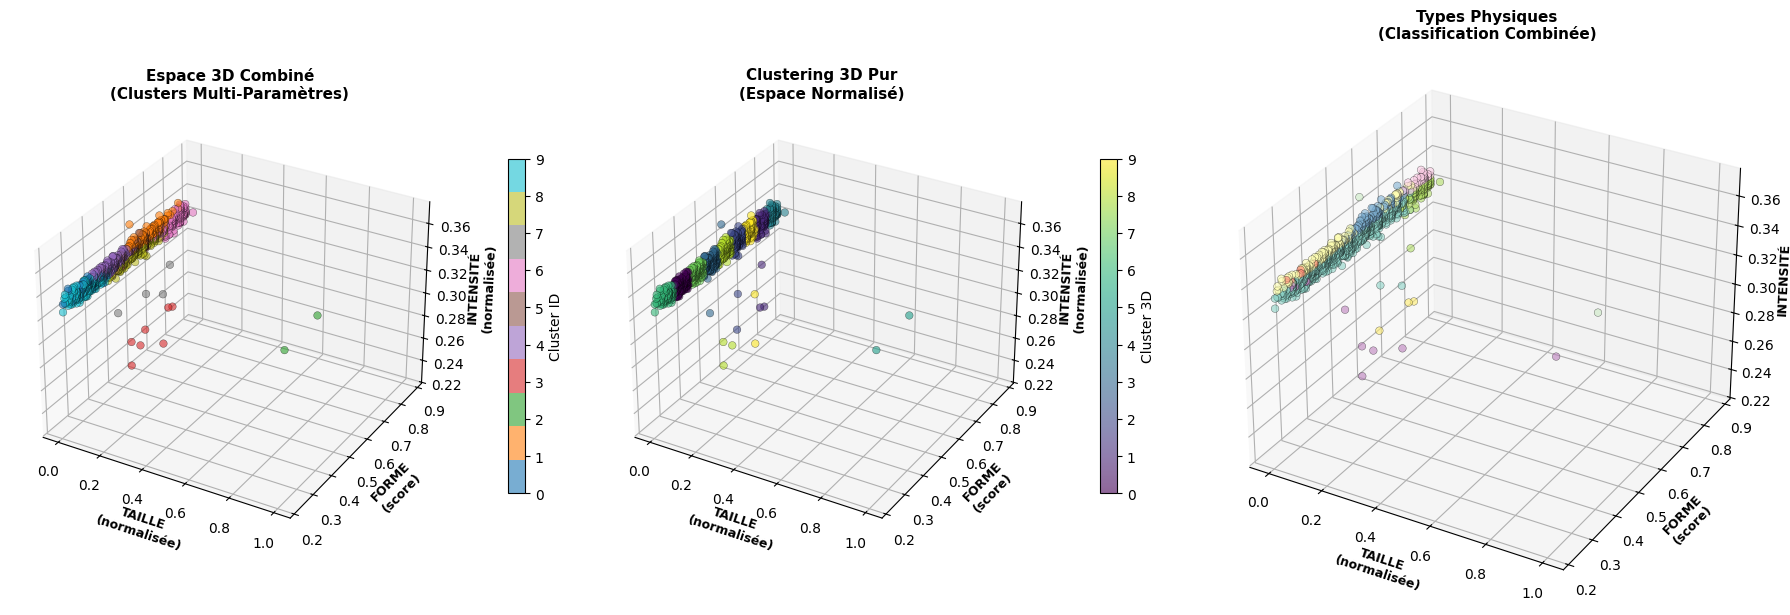

✓ Visualisation 3D combinée générée


In [36]:
print("\n📐 Génération de la visualisation 3D combinée...")

if 'Cluster_Combined' in df_particles.columns:
    fig = plt.figure(figsize=(18, 6))
    
    # Vue 1: Clusters combinés dans l'espace 3D
    ax1 = fig.add_subplot(131, projection='3d')
    scatter1 = ax1.scatter(df_particles['Size_Normalized'], 
                          df_particles['Shape_Normalized'],
                          df_particles['Intensity_Normalized'],
                          c=df_particles['Cluster_Combined'], 
                          cmap='tab10', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
    ax1.set_xlabel('TAILLE\n(normalisée)', fontsize=9, fontweight='bold')
    ax1.set_ylabel('FORME\n(score)', fontsize=9, fontweight='bold')
    ax1.set_zlabel('INTENSITÉ\n(normalisée)', fontsize=9, fontweight='bold')
    ax1.set_title('Espace 3D Combiné\n(Clusters Multi-Paramètres)', fontsize=11, fontweight='bold')
    plt.colorbar(scatter1, ax=ax1, label='Cluster ID', shrink=0.6, pad=0.1)
    
    # Vue 2: Clusters 3D purs
    if 'Cluster_3D' in df_particles.columns:
        ax2 = fig.add_subplot(132, projection='3d')
        scatter2 = ax2.scatter(df_particles['Size_Normalized'], 
                              df_particles['Shape_Normalized'],
                              df_particles['Intensity_Normalized'],
                              c=df_particles['Cluster_3D'], 
                              cmap='viridis', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
        ax2.set_xlabel('TAILLE\n(normalisée)', fontsize=9, fontweight='bold')
        ax2.set_ylabel('FORME\n(score)', fontsize=9, fontweight='bold')
        ax2.set_zlabel('INTENSITÉ\n(normalisée)', fontsize=9, fontweight='bold')
        ax2.set_title('Clustering 3D Pur\n(Espace Normalisé)', fontsize=11, fontweight='bold')
        plt.colorbar(scatter2, ax=ax2, label='Cluster 3D', shrink=0.6, pad=0.1)
    
    # Vue 3: Types de particules physiques
    if 'Particle_Type_Combined' in df_particles.columns:
        ax3 = fig.add_subplot(133, projection='3d')
        
        # Mapper les types à des couleurs
        unique_types = df_particles['Particle_Type_Combined'].unique()
        type_to_num = {t: i for i, t in enumerate(unique_types)}
        color_nums = df_particles['Particle_Type_Combined'].map(type_to_num)
        
        scatter3 = ax3.scatter(df_particles['Size_Normalized'], 
                              df_particles['Shape_Normalized'],
                              df_particles['Intensity_Normalized'],
                              c=color_nums, 
                              cmap='Set3', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
        ax3.set_xlabel('TAILLE\n(normalisée)', fontsize=9, fontweight='bold')
        ax3.set_ylabel('FORME\n(score)', fontsize=9, fontweight='bold')
        ax3.set_zlabel('INTENSITÉ\n(normalisée)', fontsize=9, fontweight='bold')
        ax3.set_title('Types Physiques\n(Classification Combinée)', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualisation 3D combinée générée")

## 9️⃣.2 Histogramme des Intensités avec Seuils


📊 Génération de l'histogramme des intensités...


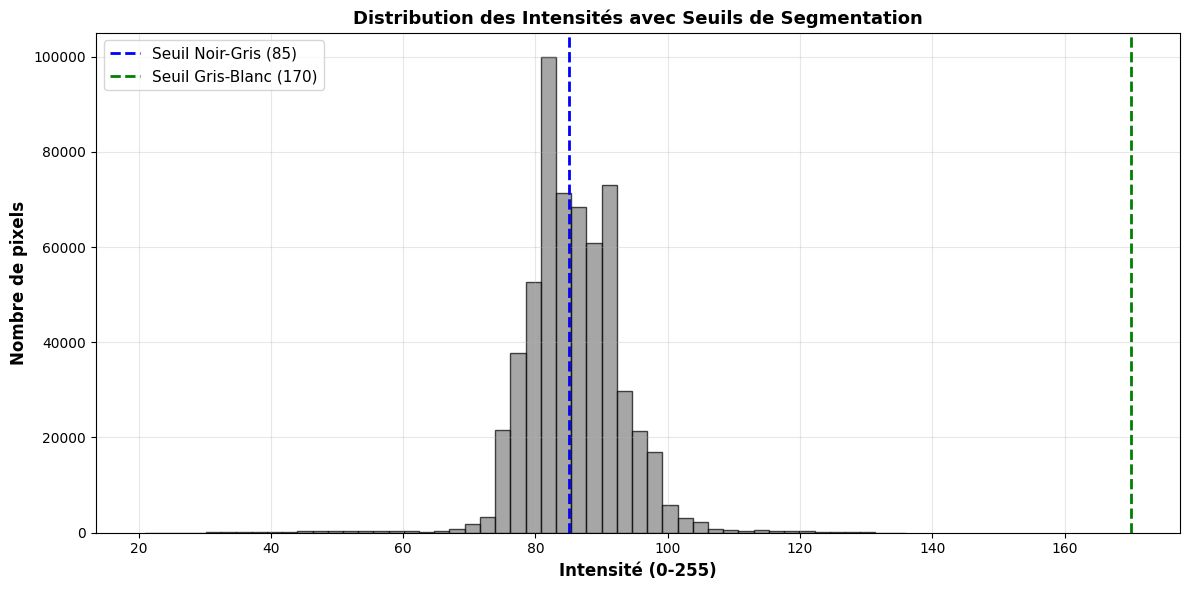

✓ Histogramme des intensités généré


In [37]:
print("\n📊 Génération de l'histogramme des intensités...")

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(gray_eq.ravel(), bins=50, color='gray', alpha=0.7, edgecolor='black')
ax.axvline(thresh1, color='blue', linestyle='--', linewidth=2, label=f'Seuil Noir-Gris ({thresh1})')
ax.axvline(thresh2, color='green', linestyle='--', linewidth=2, label=f'Seuil Gris-Blanc ({thresh2})')
ax.set_xlabel('Intensité (0-255)', fontweight='bold', fontsize=12)
ax.set_ylabel('Nombre de pixels', fontweight='bold', fontsize=12)
ax.set_title('Distribution des Intensités avec Seuils de Segmentation', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Histogramme des intensités généré")

## 🔟 Rapport Final et Sauvegarde des Résultats

In [38]:
print("\n" + "="*80)
print("📋 RAPPORT FINAL - CLUSTERING COMBINÉ (TAILLE × FORME × INTENSITÉ)")
print("="*80)

print(f"\n📊 DONNÉES GÉNÉRALES:")
print(f"  Total particules détectées: {len(df_particles)}")
print(f"  Dimensions image: {gray.shape}")
print(f"  Clusters identifiés: {n_main_clusters}")
print(f"  Types de particules uniques: {df_particles['Particle_Type_Combined'].nunique()}")

print(f"\n🔬 SEGMENTATION INITIALE PAR INTENSITÉ:")
for type_name in ['Type_1_Blanc', 'Type_2_Gris', 'Type_3_Noir']:
    count = len(df_particles[df_particles['Type'] == type_name])
    pct = 100 * count / len(df_particles) if len(df_particles) > 0 else 0
    avg_size = df_particles[df_particles['Type'] == type_name]['Size_Score'].mean()
    print(f"  {type_name}: {count} particules ({pct:.1f}%) - Taille moy: {avg_size:.1f} px²")

print(f"\n🎯 CLUSTERING COMBINÉ MULTI-PARAMÈTRES:")
print(f"  Nombre de clusters: {n_main_clusters}")
print(f"  Méthode: KMeans avec pondération (Taille + Forme + Intensité)")

print(f"\n📐 CLUSTERING 3D:")
print(f"  Nombre de clusters 3D: {n_3d_clusters}")

print(f"\n🏷️ CLASSIFICATION PHYSIQUE COMBINÉE:")
print(f"  Types uniques identifiés: {df_particles['Particle_Type_Combined'].nunique()}")
print(f"\n  Top 10 types:")
for idx, (ptype, count) in enumerate(df_particles['Particle_Type_Combined'].value_counts().head(10).items(), 1):
    pct = 100 * count / len(df_particles)
    print(f"    {idx:2d}. {ptype}: {count:3d} ({pct:5.1f}%)")

print(f"\n📈 STATISTIQUES DES 3 DIMENSIONS:")
print(f"  TAILLE (Surface):")
print(f"    Min: {df_particles['Size_Score'].min():.1f} px²")
print(f"    Max: {df_particles['Size_Score'].max():.1f} px²")
print(f"    Moyenne: {df_particles['Size_Score'].mean():.1f} px²")
print(f"    Médiane: {df_particles['Size_Score'].median():.1f} px²")

print(f"\n  FORME (Score composite):")
print(f"    Min: {df_particles['Shape_Score'].min():.3f}")
print(f"    Max: {df_particles['Shape_Score'].max():.3f}")
print(f"    Moyenne: {df_particles['Shape_Score'].mean():.3f}")

print(f"\n  INTENSITÉ:")
print(f"    Min: {df_particles['Intensity_Score'].min():.1f}/255")
print(f"    Max: {df_particles['Intensity_Score'].max():.1f}/255")
print(f"    Moyenne: {df_particles['Intensity_Score'].mean():.1f}/255")

print("\n" + "="*80)
print("✅ ANALYSE STATISTIQUE COMPLÈTE TERMINÉE!")
print("="*80)


📋 RAPPORT FINAL - CLUSTERING COMBINÉ (TAILLE × FORME × INTENSITÉ)

📊 DONNÉES GÉNÉRALES:
  Total particules détectées: 1005
  Dimensions image: (624, 928)
  Clusters identifiés: 10
  Types de particules uniques: 9

🔬 SEGMENTATION INITIALE PAR INTENSITÉ:
  Type_1_Blanc: 0 particules (0.0%) - Taille moy: nan px²
  Type_2_Gris: 544 particules (54.1%) - Taille moy: 539.5 px²
  Type_3_Noir: 461 particules (45.9%) - Taille moy: 533.3 px²

🎯 CLUSTERING COMBINÉ MULTI-PARAMÈTRES:
  Nombre de clusters: 10
  Méthode: KMeans avec pondération (Taille + Forme + Intensité)

📐 CLUSTERING 3D:
  Nombre de clusters 3D: 10

🏷️ CLASSIFICATION PHYSIQUE COMBINÉE:
  Types uniques identifiés: 9

  Top 10 types:
     1. Carbone_Dispersé: 606 ( 60.3%)
     2. Particule_Transition_Ronde: 144 ( 14.3%)
     3. Particule_Transition_Anguleuse: 108 ( 10.7%)
     4. Carbone_Amorphe_Fin:  90 (  9.0%)
     5. Particule_Transition_Compacte:  36 (  3.6%)
     6. Agglomérat_Carbone:  11 (  1.1%)
     7. Dépôt_Poreux:   5 ( 

In [39]:
# Sauvegarder tous les résultats
print("\n💾 SAUVEGARDE DES RÉSULTATS...")
print("="*80)

# 1. Données principales
df_particles.to_csv("particles_by_intensity_types.csv", index=False)
print("✓ particles_by_intensity_types.csv")

# 2. Résumés clustering
if 'Cluster_Combined' in df_particles.columns:
    cluster_combined_summary = df_particles.groupby('Cluster_Combined').agg({
        'Size_Score': ['count', 'mean', 'std'],
        'Shape_Score': ['mean', 'std'],
        'Intensity_Score': ['mean', 'std']
    }).round(3)
    cluster_combined_summary.to_csv("cluster_combined_summary.csv")
    print("✓ cluster_combined_summary.csv")

if 'Cluster_3D' in df_particles.columns:
    cluster_3d_summary = df_particles.groupby('Cluster_3D').agg({
        'Size_Normalized': ['count', 'mean', 'std'],
        'Shape_Normalized': ['mean', 'std'],
        'Intensity_Normalized': ['mean', 'std']
    }).round(4)
    cluster_3d_summary.to_csv("cluster_3d_summary.csv")
    print("✓ cluster_3d_summary.csv")

# 3. Distributions
particle_type_distribution = df_particles['Particle_Type_Combined'].value_counts()
particle_type_distribution.to_csv("particle_types_combined_distribution.csv", header=['Count'])
print("✓ particle_types_combined_distribution.csv")

# 4. Matrices de confusion
if 'Particle_Type_Combined' in df_particles.columns:
    confusion_matrix = pd.crosstab(
        df_particles['Type'], 
        df_particles['Particle_Type_Combined'],
        margins=True,
        margins_name='TOTAL'
    )
    confusion_matrix.to_csv("confusion_matrix_types.csv")
    print("✓ confusion_matrix_types.csv")

# 5. Tableaux croisés
if 'Cluster_Combined' in df_particles.columns:
    crosstab_intensity = pd.crosstab(
        df_particles['Cluster_Combined'],
        df_particles['Type']
    )
    crosstab_intensity.to_csv("crosstab_clusters_vs_intensity.csv")
    print("✓ crosstab_clusters_vs_intensity.csv")

# 6. Résultats PCA
pca_results = pd.DataFrame({
    'PCA_1': df_particles['PCA_1'],
    'PCA_2': df_particles['PCA_2'],
    'PCA_3': df_particles['PCA_3'],
    'Cluster_Combined': df_particles['Cluster_Combined'],
    'Type': df_particles['Type']
})
pca_results.to_csv("pca_3d_results.csv", index=False)
print("✓ pca_3d_results.csv")

# 7. Zone équilibrée
zone_info = {
    'Center_X': x_center,
    'Center_Y': y_center,
    'TopLeft_X': x_topleft,
    'TopLeft_Y': y_topleft,
    'Window_Size': square_size,
    'Total_Particles': best_window['n_particles'],
    'Total_Clusters': total_clusters
}

for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
    count = region_cluster_counts.get(cluster_id, 0)
    zone_info[f'Cluster_{cluster_id}_Count'] = count

zone_info_df = pd.DataFrame([zone_info])
zone_info_df.to_csv("zone_equilibree_info.csv", index=False)
print("✓ zone_equilibree_info.csv")

# 8. Meilleur échantillon
best_sample_info = {
    'Center_X': x_center,
    'Center_Y': y_center,
    'Total_Clusters': total_clusters,
    'Total_Particles_In_Zone': best_window['n_particles'],
    'Window_Size_px': square_size,
    'All_Clusters_Present': 'YES'
}
best_sample_df = pd.DataFrame([best_sample_info])
best_sample_df.to_csv("best_representative_sample.csv", index=False)
print("✓ best_representative_sample.csv")

print("\n" + "="*80)
print("✅ TOUS LES FICHIERS SAUVEGARDÉS!")
print("="*80)


💾 SAUVEGARDE DES RÉSULTATS...
✓ particles_by_intensity_types.csv
✓ cluster_combined_summary.csv
✓ cluster_3d_summary.csv
✓ particle_types_combined_distribution.csv
✓ confusion_matrix_types.csv
✓ crosstab_clusters_vs_intensity.csv
✓ pca_3d_results.csv
✓ zone_equilibree_info.csv
✓ best_representative_sample.csv

✅ TOUS LES FICHIERS SAUVEGARDÉS!
